In [1]:
import pandas as pd

import os
from datetime import datetime

from pandas.api.types import CategoricalDtype
import pylab as P

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm

import glob
import fnmatch

import statsmodels.formula.api as sm
import patsy
import collections
import re

import logging

from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('display.max_columns', 1800)
pd.set_option('display.width', 1800)

fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
import datetime
%pylab inline
sns.set(style="darkgrid")
plt.style.use('ggplot')

drop=os.getenv('DROPBOX_LOC')
box=os.getenv('BOX_LOC')

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


`TODO` March 2020: refactor, simplify:
* move away from storing RHS vars in a dict. A dataframe would be much simpler with appropriate indices.


### Notebook for predicting households by income bin


Core idea is to use information on labor market, economy, population at the county level to predict shares in each income quartile using four regressions. We use a model fitted on historic data from the past few decades to predict future shares, given data on those same variables from REMI. The approach follows one [laid out](http://www.remi.com/wp-content/uploads/2017/10/Technical_Documentation_for_Household_Forecast_Project.pdf) by REMI, inc, but with a different specification. A regression is fitted for each of four quartiles.

A note on functional form: Since regressions are not constrained in the range of the dependent variable, scaling must be done to ensure the shares from the four separate add up to 100 percent.

The notebook loads household projections from a separate notebook `REGPROJ-HHPROJ 1 - Total household projection PBA2050 Phased HR` and disaggregates household totals from each scenario / variant based on relatively  rich data from REMI on the future population (demographic, economic, wages). We estimate regressions, prepare future right hand side data, and apply regression parameters to the future state of the region to predict households in each of four income buckets.

#### Define a number of mappings 

In [2]:
## geographic mappings

bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}

## mapping for REMI area grouping
bayarearegions={'06001':'East Bay',
 '06013':'East Bay',
 '06085':'South Bay',
 '06055':'North Bay',
 '06081':'West Bay',
 '06075':'West Bay',
 '06097':'North Bay',
 '06041':'West Bay',
 '06095':'North Bay'}

north_bay =  {'06055':'North Bay',
 '06097':'North Bay',
 '06095':'North Bay'}
pd.DataFrame(data={'county':bayareafips_full,'region':bayarearegions}).to_clipboard()
pct=lambda x: x/x.sum()

In [3]:
## relate naics categories to abag classification

naics_map = {'Forestry, Fishing, and Related Activities':'Agriculture & Natural Resources', 
             u'Mining':'Agriculture & Natural Resources',
             u'Utilities':'Transportation & Utilities', 
             u'Construction':u'Construction',
             u'Manufacturing':u'Manufacturing & Wholesale',
             u'Wholesale Trade':u'Manufacturing & Wholesale',
             u'Retail Trade':u'Retail Trade',
             u'Transportation and Warehousing':'Transportation & Utilities',
             u'Information':u'Information',
             u'Finance and Insurance':'Financial & Leasing',
             u'Real Estate and Rental and Leasing':'Professional & Managerial Services',
             u'Professional, Scientific, and Technical Services':'Professional & Managerial Services',
             u'Management of Companies and Enterprises':'Professional & Managerial Services',
             u'Administrative and Waste Management Services':'Professional & Managerial Services',
             u'Educational Services; private':'Health & Educational Services',
             u'Health Care and Social Assistance':'Health & Educational Services',
             u'Arts, Entertainment, and Recreation':'Arts, Recreation & Other Services',
             u'Accommodation and Food Services':'Arts, Recreation & Other Services',
             u'Other Services, except Public Administration':'Arts, Recreation & Other Services',
             u'State and Local Government Employment':'Government',
             u'Federal Civilian Employment':'Government',
             u'Federal Military Employment':'Government'}

In [4]:
## map remi occ groups to census major ones--this is dirty, bc the census ones shift.
occ_to_census = {u'Management, business, and financial occupations':'occ_mgmt',
u'Computer, mathematical, architecture, and engineering occupations':'occ_mgmt',
u'Life, physical, and social science occupations':'occ_mgmt',
u'Community and social service occupations':'occ_svcs',
u'Legal occupations':'occ_mgmt',
u'Education, training, and library occupations':'occ_svcs',
u'Arts, design, entertainment, sports, and media occupations':'occ_svcs',
u'Healthcare occupations':'occ_svcs',
u'Protective service occupations':'occ_svcs',
u'Food preparation and serving related occupations':'occ_sls',
u'Building and grounds cleaning and maintenance,personal care and service occupations':'occ_svcs',
u'Sales and related, office and administrative support occupations':'occ_sls',
u'Farming, fishing, and forestry occupations':'occ_nat',
u'Construction and extraction occupations':'occ_nat',
u'Installation, maintenance, and repair occupations':'occ_prod',
u'Production occupations':'occ_prod',
u'Transportation and material moving occupations':'occ_prod',
u'Military':'occ_other'}


In [5]:
## this table is custom generated in REMI--mxing in govt as industry employment

indus_to_census={u'State and Local Government':'ind_public',
u'Federal Civilian':'ind_public',
u'Federal Military':'ind_public',
u'Forestry, Fishing, and Related Activities':'ind_other',
u'Mining':'ind_other',
u'Utilities':'ind_other',
u'Construction':'ind_other',
u'Manufacturing':'ind_other',
u'Wholesale Trade':'ind_other',
u'Retail Trade':'ind_retail',
u'Transportation and Warehousing':'ind_other',
u'Information':'ind_prof',
u'Finance and Insurance':'ind_prof',
u'Real Estate and Rental and Leasing':'ind_prof',
u'Professional, Scientific, and Technical Services':'ind_prof',
u'Management of Companies and Enterprises':'ind_prof',
u'Administrative and Waste Management Services':'ind_other',
                 'Administrative, Support, Waste Management, And Remediation Services':'ind_other',
u'Educational Services':'ind_educ',
u'Educational Services; private':'ind_educ',
u'Health Care and Social Assistance':'ind_health',
u'Arts, Entertainment, and Recreation':'ind_other',
u'Accommodation and Food Services':'ind_accom_food_svcs',
u'Other Services, except Public Administration':'ind_other',
                u'Other Services':'ind_other'}

## mapping that collapses finer to coarser age bins in the remi output

agemapcollapser={u'Ages 0-15':u'Ages 0-15', u'Ages 16-19':u'Ages 16-19', u'Ages 20-21':u'Ages 20-24', u'Ages 22-24':u'Ages 20-24',
 u'Ages 25-29':u'Ages 25-34', u'Ages 30-34':u'Ages 25-34',
 u'Ages 35-44':u'Ages 35-44', u'Ages 45-54':u'Ages 45-54', u'Ages 55-59':u'Ages 55-64',
 u'Ages 60-61':u'Ages 55-64', u'Ages 62-64':u'Ages 55-64', u'Ages 65-69':u'Ages 65+', u'Ages 70-74':u'Ages 65+',
 u'Ages 75+':u'Ages 65+'}
set(agemapcollapser.values())

{u'Ages 0-15',
 u'Ages 16-19',
 u'Ages 20-24',
 u'Ages 25-34',
 u'Ages 35-44',
 u'Ages 45-54',
 u'Ages 55-64',
 u'Ages 65+'}

In [6]:
## prepare slicer object for subsetting dataframes

idx = pd.IndexSlice

In [7]:
## mapping from year to ACS / census  source

yr_to_vintage={1990:'C1990',1991:'C1990',2000:'C2000',2005:'ACS2005',2006:'ACS2006',2007:'ACS2007',
2008:'ACS2008',2009:'ACS2009',2010:'ACS2010',2011:'ACS2011',2012:'ACS2012',2013:'ACS2013',2014:'ACS2014',
2015:'ACS2015',2016:'ACS2016',2017:'ACS2017',2018:'ACS2018'}

In [8]:
## map from quarter to first month in quarter

qtrmap = {1:'01',2:'04',3:'07',4:'10'}

In [9]:
## convenience label function
def agebreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr}-{to}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels
#agebreaker(range(0,86,5))

def agebreaker2(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr:.0f}-{to:.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels

breaks_5 =range(0,86,5)+[np.inf]
#diffbreaks_5 =range(0,76,5)+[np.inf]

diffbreaks_custom =[0,5]+range(20,90,5)+[np.inf]
age_coarse=[0,5,15,25,65,inf]

In [10]:
def classifier(df):
    """
    we need to classify each row with the appropriate hierarchy level.
    for each row, we want to get the rightmost value available--
    that represents the finest grained detail class
    """
    
    x = df.ix[:4].tolist()
    try:
        out = next(s for s in x if not s is np.NaN)
    except:
        out = None
    return  out

def classlevel(s):
    
    try:
        if s[3:]=='0000':
            return 'major'
        elif np.float64(s[3:]) % 100==0:
            return 'minor'
        elif np.float64(s[3:]) % 10==0:
            return 'broad'
        else:
            return 'detail'
    except:
        return 'none'

In [11]:
## old school format wrappers
def f1(x):
    return '%.4f' % x
def f4(x):
    return '%.4f' % x if x>0 else ''

In [12]:
## helper function to adjust the wharton index at a passed rate, implying either more or less hardship in the future

def adjust_wharton(rv_wharton_geo_input,rate=1.03,regions=['West Bay']):
    rv_wharton_geo_t = rv_wharton_geo_input.T.copy()
    
    for r in regions:  
                ## grow the last value (2014) with 1% per year to 2040
        subreg = rv_wharton_geo_t.ix[:,r]
        subreg_last =subreg.ix[2014]
        
        subreg.ix[range(2014,2051)]=subreg_last*np.multiply.accumulate(np.full(subreg.ix[range(2015,2051)].shape[0], fill_value=rate))

        ## move back to orig dataframe
        rv_wharton_geo_t.ix[:,r]=subreg
    rv_wharton_geo=rv_wharton_geo_t.T
    return rv_wharton_geo

def adjust_wharton_variable(rv_wharton_geo_input,regionrates=None):
    rv_wharton_geo_t = rv_wharton_geo_input.T.copy()
    
    for reg,rates in regionrates.iteritems():  
                ## grow the last value (2014) with 1% per year to 2040
        subreg = rv_wharton_geo_t.loc[:,reg]
        subreg_last =subreg.loc[2014]
        
        subreg.loc[range(2015,2051)]=subreg_last*np.multiply.accumulate(np.full(subreg.loc[range(2015,2051)].shape[0], fill_value=rates))

        ## move back to orig dataframe
        #rv_wharton_geo_t.loc[:,reg]=subreg
        rv_wharton_geo_t.update(subreg)
    rv_wharton_geo=rv_wharton_geo_t.T
    return rv_wharton_geo


#### Helper function to get the lastest household total projection based on time stamp embedded in file name
(`REGPROJ-HHPROJ 1 - Total household projection PBA2050 Phased HR.ipynb`)

In [13]:
def get_latest_scenario_proj(scenario=None,use_eased=False):
    #candidates=glob.glob(os.path.join(drop,'Data/PBA2050/household_forecast/%s'%scenario))
    ## the household projection spits out two versions; a raw one and one with a 
    ## post-processing convergence between observed and estimated through 2030. We can use either.
    
    if not use_eased:
        candidates=glob.glob(os.path.join(drop,'Data/PBA2050/household_forecast/{scen}/proj_region_hh_sc_*_{hr}_2*'.format(scen=scenario,hr=scenario_to_headship_map[scenario])))
    else:
        candidates=glob.glob(os.path.join(drop,'Data/PBA2050/household_forecast/{scen}/proj_region_hh_sc_*_{hr}_eased*'.format(scen=scenario,hr=scenario_to_headship_map[scenario])))
    
    
    #candidates=glob.glob(os.path.join(box,'EDF Shared work/control_totals',scenario,'households/proj_regionhh_scenario_%s*'%scenario))
    #return candidates
    out={}
    for i,f in enumerate(candidates):
        #print f
        tmp=re.search('(\d{8}_\d{6})',f)
        date = datetime.datetime.strptime(tmp.group(0),'%Y%m%d_%H%M%S')
        #print i,date
        out[(i,f)]=date
    latest = pd.Series(out).reset_index(name='date').sort_values('date',ascending=False).iloc[0]
    return latest.level_1

In [14]:
## Also a helper function to format output from a statsmodel regression model object into a simpler table 
## TODO: March 2020 - time to refactor some of these

def statswrapper(modeloutput):
    statistics = pd.Series({'r2': modeloutput.rsquared,
                  'adj_r2': modeloutput.rsquared_adj})
    # put them togher with the result for each term
    result_df = pd.DataFrame({'params': modeloutput.params,
                              'pvals': modeloutput.pvalues,
                              'std': modeloutput.bse,
                              'test_stats': statistics})
    # add the complexive results for f-value and the total p-value
    fisher_df = pd.DataFrame({'params': {'_f_test': modeloutput.fvalue},
                              'pvals': {'_f_test': modeloutput.f_pvalue}})
    # merge them and unstack to obtain a hierarchically indexed series
    res_series = pd.concat([result_df, fisher_df]).sort_values('test_stats')
    res_series['test_stats'].apply(lambda x: np.nan if x==0 else x)

    return res_series#.dropna()

In [15]:
## convenience function for passing a set of variables and estimating a regression with those variables
## map bin numbers to names in PUMS file

## TODO: March 2020 - time to refactor some of these

def run_model(modeldata,rhsvars,inc_cat=1):
    cat_rhs='+'.join(rhsvars)
    cat = sm.ols(depvar[inc_cat]+' ~ ' +cat_rhs, data=modeldata).fit()
    #cat = sm.wls(dataformodels[depvar[inc_cat]]+' ~ ' +cat_rhs, weights = 'population',data=dataformodels).fit()
    print '*'*80,'\n'
    print "SUMMARY FOR INCOME BIN %s, (%s)"%(inc_cat,'dep var: PUMS based shares' if use_pums_shares else 'fuzzy dep var')
    print cat.summary2()
    toxls = statswrapper(cat).fillna(0)
    toxls.to_excel(xlsmodel,sheet_name='inc_cat_%s'%(inc_cat))
    pd.DataFrame(toxls).to_latex(os.path.join(drop,'Data/incomeregressions_cat__{}.tex'.format(inc_cat,datetime.datetime.now())),na_rep='',formatters=[f1,f1,f1,f4])
    #pd.DataFrame(toxls).to_latex(os.path.join(r'N:\Planning\ABAG Forecasting Models\Household Module\Documentation','incomeregressions_cat__{}.tex'.format(inc_catdatetime.datetime.now())),na_rep='',formatters=[f1,f1,f1,f4])
    #{:%Y%m%d_%H%M%S}
    cat_params = cat.params.to_dict()
    cat_params['bin']='cat'+str(inc_cat)
    return cat_params

In [16]:
## load national county size file

county_area=pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/county_area.csv'),dtype = {'geoid':object,'geoid.1':object}).set_index('geoid')
aland = county_area.aland

### Data for estimating regressions

The data is from a separate notebook which calls up the census API, gets the data for each county, and packages it as appropriate into desired variables.



In [17]:
## load county-level census data for the past few decades

dataformodels = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/censusdata.csv'))

#dataformodels=pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/allyears_feb2020upd.csv'))
dataformodels.geoid10=dataformodels.geoid10.map(lambda x: '{:05d}'.format(x))
dataformodels.state=dataformodels.state.map(lambda x: '{:02d}'.format(x))
dataformodels.division=dataformodels.division.map(lambda x: '{:02d}'.format(x))
dataformodels=dataformodels.set_index(['vintage','geoid10'])
dataformodels.head(2)

pop_to_hh   is_bay_area     lf  inc_retirement    inc_wage   inc_rental  inc_self_emp  inc_public_asst     is_bay_area2  median_home_value  inc_cat_1  inc_cat_2  inc_cat_3  inc_cat_4  inc_cat_5     hh   remi_region   is_north_bay  population    density  per_capita_inc  ag_15_24  ag_25_64    ag_65p  Swhite_NH  Sblack_NH  Sother_NH  Shispanic       SLF     w_sex        aland  ind_educ  ind_retail  ind_public  ind_accom_food_svcs  ind_health  ind_prof  hhshare_q1  hhshare_q2  hhshare_q3  hhshare_q4  inc_cat_1_tot  inc_cat_2_tot  inc_cat_3_tot  inc_cat_4_tot  inc_cat_5_tot  built_past_decade  lt_20min_worktravel  occ_tot  occ_mgmt  occ_svcs   occ_sls   occ_nat  occ_prod vintage.1  hhinc_q1  hhinc_q2  hhinc_q3  hhinc_q4  years state  inc_cat_1_pums  inc_cat_2_pums  inc_cat_3_pums  inc_cat_4_pums    WRLURI metroconcept          msasize  us_median_home_value  per_capita_inc_adj2009  median_home_value_adj2009  us_median_home_value_adj2009  inc_retirement_adj2009  inc_wage_adj2009  inc_rental_adj2009  inc_self_emp_adj2009  inc_public_asst_adj2009  cnty_to_us      bin1      bin2      bin3      bin4 division
vintage geoid10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
ACS2010 01003     0.395219  not bay area  84253     395875200.0  3088521500  280365100.0   308500100.0        2274200.0  ouside bay area           177200.0   0.392769   0.304782    0.19519   0.107260   0.302450  69476  not bay area  not north bay      175791  42.692287         26469.0  0.115723  0.526591  0.164912   0.840777   0.093793   0.026475   0.038955  0.602767  0.511340  4117.629064  0.068721    0.137723    0.045950             0.078732    0.110494  0.098688    0.226711    0.271518    0.199321    0.302450          27288          21175          13561           7452          21013           0.310120             0.426655    78520  0.315219  0.175586  0.268785  0.134832  0.105578   ACS2010  0.226711  0.271518  0.199321  0.302450   2010    01        0.402239        0.336995        0.136518        0.124248 -0.790027        19300  up to 1,000,000                188400            25792.938355              172674.021555                 183587.955198            3.857639e+08      3.009636e+09        2.732041e+08          3.006205e+08             2.216113e+06    0.940552  0.226711  0.271518  0.199321  0.302450       06
        01055     0.399593  not bay area  46024     146297800.0  1422221100   71733900.0   123505900.0        1305800.0  ouside bay area            98200.0   0.542949   0.253174    0.14799   0.055887   0.203876  41584  not bay area  not north bay      104066  75.056299         20439.0  0.128294  0.526599  0.155815   0.798436   0.148819   0.021957   0.030788  0.554239  0.517489  1386.505888  0.085529    0.111466    0.051269             0.069052    0.164308  0.074206    0.182450    0.299755    0.227756    0.290039          22578          10528           6154           2324           8478           0.074658          

In [18]:
## Appendix from 2020 on occupations

dataformodels_occdet = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/censusdata_occvars.csv'))
dataformodels_occdet.geoid10=dataformodels_occdet.geoid10.map(lambda x: '{:05d}'.format(x))
dataformodels_occdet=dataformodels_occdet.set_index(['vintage','geoid10'])
dataformodels_occdet.head(2)

occ_det_mgmt  occ_det_biz  occ_det_comp  occ_det_community  occ_det_lgl  occ_det_hlthsup  occ_det_foodprep  occ_det_officeadmin
vintage geoid10                                                                                                                                 
ACS2010 01001        0.080440     0.041206      0.019884           0.012119     0.009531         0.019391          0.050737             0.164085
        01003        0.096319     0.034030      0.010838           0.012086     0.011513         0.015601          0.060061             0.120110

In [19]:
## add extra occupation detail
dataformodels=dataformodels.join(dataformodels_occdet)

In [20]:
## load msa classifiers for each census vintage

msaclass = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/msamappings_1990_2013.csv'),dtype=object,index_col=0)

msaclass['geoid']=msaclass.geoid.apply(lambda x: "%05d" %int(x) )
msaclass=msaclass.drop_duplicates(['geoid','vintage'])

msaclass=msaclass.set_index(['vintage','geoid']).metroconcept
msaclass.index=msaclass.index.set_names(dataformodels.index.names)

## assign msa code back to county data
dataformodels['MSA_code']=msaclass

In [21]:
# 'http://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_PO_metro.txt'
## get FHFA housing price indices at metro level

metro = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/HPI_PO_metro.txt'),sep='\t')#names=['cbsa','cbsa_id','year','qtr','index'])
metro_for_stacking=    metro[['metro_name','cbsa','yr','qtr','index_nsa']].rename(columns={'metro_name':'geo','yr':'year'})
metro_for_stacking['cbsa']=metro_for_stacking.cbsa.apply(lambda x: '%05d'%int(x))
metro_for_stacking['qtrmo']=metro_for_stacking.qtr.map(qtrmap)
msaclass2 = msaclass['ACS2010'].copy()

metro_for_stacking['date']=metro_for_stacking.apply(lambda x: pd.to_datetime('%s-%s-%s' %(x['qtrmo'],'01',x.year) ),axis=1)
metro_for_stacking['vintage']=metro_for_stacking.year.map(yr_to_vintage)
metro_for_stacking_m = metro_for_stacking.merge(msaclass2.reset_index(),left_on='cbsa',right_on='metroconcept',how='inner').rename(columns={'geoid':'geoid10'})
metro_for_stacking_m=metro_for_stacking_m.ix[(metro_for_stacking_m.vintage.notnull()) & (metro_for_stacking_m.qtr==1)].set_index(['vintage','geoid10'])#.unstack(3)

dataformodels['fhfa']= metro_for_stacking_m.index_nsa

In [22]:
## subset to just counties in top 50 msas by population, each period

vintage_MSA_sizes=dataformodels.reset_index().groupby(['vintage','MSA_code']).population.sum()
vintage_top50_msas=vintage_MSA_sizes.groupby(level='vintage',group_keys=False).nlargest(50)
vintage_top30_msas=vintage_MSA_sizes.groupby(level='vintage',group_keys=False).nlargest(30)
vintage_top70_msas=vintage_MSA_sizes.groupby(level='vintage',group_keys=False).nlargest(70)

dataformodels_top50msas=dataformodels.reset_index().merge(vintage_top50_msas,on=['vintage','MSA_code'],how='inner').set_index(['vintage','geoid10'])
dataformodels_top70msas=dataformodels.reset_index().merge(vintage_top70_msas,on=['vintage','MSA_code'],how='inner').set_index(['vintage','geoid10'])
dataformodels_top30msas=dataformodels.reset_index().merge(vintage_top30_msas,on=['vintage','MSA_code'],how='inner').set_index(['vintage','geoid10'])

In [23]:
#dataformodels.reset_index().to_excel(os.path.join(box,'Modeling and Surveys/Regional Modeling/Housing/PBA50 Housing/PBA50 Household Forecast/input data/censusdata_countylevel_multidecade.xlsx'))

### Load starting / observed income distributions

In [24]:
depvar={1: 'inc_cat_1_pums',
 2: 'inc_cat_2_pums',
 3: 'inc_cat_3_pums',
 4: 'inc_cat_4_pums'}


In [25]:
## OBSERVED household income distribution COUNTS, three snapshots, from census summary files (not PUMS)
## the non-pums version lacks precision since it comes from binned data

incshares_nonpums = dataformodels.ix[dataformodels.is_bay_area!='not bay area',
            ['inc_cat_%s_tot'%x for x in range(1,5)]+['remi_region','years']]

incshares_nonpums=incshares_nonpums.set_index(['remi_region','years'],append=True,inplace=False)
incshares_nonpums['what']='historic'
incshares_nonpums=incshares_nonpums.groupby(level=[0,3,2])[['inc_cat_%s_tot'%x for x in range(1,5)]].sum().stack().groupby(level=[0,1,2]).apply(lambda x: x/x.sum()).unstack([2])
incshares_nonpums['what']='observed'
incshares_nonpums=incshares_nonpums.set_index('what',append=True)

incshares_nonpums_long=incshares_nonpums.stack().reset_index(name='share').rename(columns={'level_2':'inc_cat'})

incshares_nonpums.head(2)

remi_region                           East Bay  North Bay  South Bay  West Bay
vintage years               what                                              
ACS2010 2010  inc_cat_1_tot observed  0.276902   0.292201   0.226128  0.261124
              inc_cat_2_tot observed  0.234718   0.272396   0.207307  0.214626

In [26]:
incshares_nonpums_acs = incshares_nonpums.groupby(level=[0,2]).sum()
incshares_nonpums_acs=incshares_nonpums_acs.rename(columns={'inc_cat_1_tot':'bin_1','inc_cat_2_tot':'bin_2','inc_cat_3_tot':'bin_3','inc_cat_4_tot':'bin_4'})
incshares_nonpums_acs['year'] = pd.Series(pd.Series(incshares_nonpums_acs.index.get_level_values(0)).map({'ACS2010':2010,'ACS2013':2013,'C1990':1990,'C2000':2000}).values,
                                          index=incshares_nonpums_acs.index)
incshares_nonpums_acs.set_index('year',append=True,inplace=True)

incshares_nonpums_acs.head(2)

remi_region                 East Bay  North Bay  South Bay  West Bay
vintage               year                                          
ACS2010 inc_cat_1_tot 2010  0.276902   0.292201   0.226128  0.261124
        inc_cat_2_tot 2010  0.234718   0.272396   0.207307  0.214626

In [27]:
## generated with http://localhost:8888/notebooks/analysis/topical/population/IPUMS%20income.ipynb#

## load pums income shares since 1990
## county-level, U.S., with poor coverage in small-population counties that are smaller than 100,000 threshold
## this is immaterial insofar as we are focused on the larger CBSAs

incshares_pums = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/pums_county_income_shares_1990_2013.csv'))
incshares_pums['geoid10']=incshares_pums.STCOUNTY.apply(lambda x: "%05d" %int(x) )
incshares_pums['vintage']=incshares_pums.YEAR.map(yr_to_vintage)
incshares_pums.set_index(['vintage','geoid10'],inplace=True)

## income bins using PUMS data

hhshare_pums_q1 = incshares_pums.inc_cat_1
hhshare_pums_q1.name='hhshare_pums_q1'
hhshare_pums_q2 = incshares_pums.inc_cat_2
hhshare_pums_q2.name='hhshare_pums_q2'
hhshare_pums_q3 = incshares_pums.inc_cat_3
hhshare_pums_q3.name='hhshare_pums_q3'
hhshare_pums_q4 = incshares_pums.inc_cat_4
hhshare_pums_q4.name='hhshare_pums_q4'


In [28]:
## load pums income shares since 1990
## BAY AREA subregion detail

incshare_pums_bayarea_subregions = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/pums_bayarea_income_shares_1990_2013.csv'),
                                           names=['years','remi_region']+['inc_cat_%s_tot'%x for x in range(1,5)],skiprows=1)
incshare_pums_bayarea_subregions['vintage']=incshare_pums_bayarea_subregions.years.map(yr_to_vintage)
incshare_pums_bayarea_subregions=incshare_pums_bayarea_subregions.ix[incshare_pums_bayarea_subregions.remi_region!='outside bay area']
incshare_pums_bayarea_subregions['what']='pba2017'

incshare_pums_bayarea_subregions=incshare_pums_bayarea_subregions.set_index(['vintage','years','what','remi_region']).stack().reset_index(name='value').rename(columns={'level_4':'inc_cat'})        
incshare_pums_bayarea_subregions.head(2)

,vintage,years,what,remi_region,inc_cat,value
0,C1990,1990,pba2017,East Bay,inc_cat_1_tot,0.255488
1,C1990,1990,pba2017,East Bay,inc_cat_2_tot,0.292561


In [29]:
mtc_pba2013=pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/mtc2010_2040_inccats.csv'),index_col=0)

In [30]:
## observed starting distribution

incshares_pums_recent = pd.read_excel(os.path.join(box,'EDF Shared work/control_totals/base_data/pums_remireg_income_shares_2006_2018_pct.xlsx'),dtype={'STCOUNTY':str}).rename(columns={'YEAR':'vintage'})
incshares_pums_recent.vintage=incshares_pums_recent.vintage.map(yr_to_vintage)

bayareashares_pums_2015=incshares_pums_recent[incshares_pums_recent.vintage=='ACS2015'].set_index(['remi_region']).filter(regex='inc_cat').rename(columns=lambda x: x+'_tot')
bayareashares_pums_2015

,inc_cat_1_tot,inc_cat_2_tot,inc_cat_3_tot,inc_cat_4_tot
remi_region,,,,
East Bay,0.268097,0.261035,0.224631,0.246237
North Bay,0.316808,0.312828,0.210716,0.159648
South Bay,0.211933,0.212848,0.222073,0.353146
West Bay,0.247987,0.215210,0.208612,0.328190


In [31]:
## observed starting distribution

incshares_pums_recent_abs = pd.read_excel(os.path.join(box,'EDF Shared work/control_totals/base_data/pums_remireg_income_shares_2006_2018_abs.xlsx'),dtype={'STCOUNTY':str}).rename(columns={'YEAR':'vintage'})
incshares_pums_recent_abs.vintage=incshares_pums_recent_abs.vintage.map(yr_to_vintage)

bayareainc_pums_2015=incshares_pums_recent_abs[incshares_pums_recent_abs.vintage=='ACS2015'].set_index(['remi_region']).filter(regex='inc_cat').rename(columns=lambda x: x+'_tot')
bayareainc_pums_2015.sum()

inc_cat_1_tot    688276
inc_cat_2_tot    657079
inc_cat_3_tot    584177
inc_cat_4_tot    753096
dtype: int64

In [32]:
bayareaincomeobs=incshares_pums_recent_abs[incshares_pums_recent_abs.vintage.isin(['ACS2015','ACS2010'])].set_index('vintage').groupby(lambda x: int(x[-4:])).sum().rename(columns=lambda x: x.replace('inc_cat','bin'))

## scale to decennial household counts
#bayareaincomeobs.loc[2010]*=2608000/2546621.
bayareaincomeobs.index=bayareaincomeobs.index.set_names(['YEAR'])

In [33]:
bayareaincomeobs.sum(axis=1)

YEAR
2010    2546621
2015    2682628
dtype: int64

#### Prep non-census variables

In [34]:
# ## Load Wharton index from Gyourko. Idea is that more restrictive areas might all other things equal be more top 
# ## heavy in the income distribution

## We made a household-weighted version when aggregating jurisdictions to county
## http://localhost:8888/notebooks/analysis/topical/get%20census%20API%20place%20data%20national.ipynb

wharton_combo=pd.read_excel(os.path.join(box,'EDF Shared work/control_totals/base_data/WRLURI_weighted_and_orig.xlsx'),dtype={'geoid10':str})
WRLURI_wgt=wharton_combo.set_index('geoid10').weighted
WRLURI_wgt.name='WRLURI'

## create a frame with the index literally repeated for each census vintage. 
## The update method doesn't seem to broadcast without it

WRLURI_expanded={}
WRLURI_wgt.loc['06001']
for vint in dataformodels.index.get_level_values(0).unique():
    WRLURI_expanded[vint]=WRLURI_wgt
WRLURI_expanded=pd.concat(WRLURI_expanded,names=['vintage'])
WRLURI_expanded.head()

vintage  geoid10
ACS2010  01001     -0.991755
         01003     -0.777164
         01005     -1.613258
         01009     -1.204409
         01015     -0.324215
Name: WRLURI, dtype: float64

In [35]:
## assign to dataformodels dataframe
dataformodels.update(WRLURI_expanded)

In [36]:
## this version is household-weighted within each subregion

combo_remireg = pd.read_excel(os.path.join(box,'EDF Shared work/control_totals/base_data/WRLURI_bayarea_weighted_and_orig.xlsx'))
combo_remireg

,Region,weighted,unweighted
0,East Bay,0.622919,0.759408
1,North Bay,1.131277,1.022805
2,South Bay,0.161823,0.161942
3,West Bay,1.724180,0.965146


In [37]:
# ## grow index negatively (i.e. slightly less restrictive as policies are adjusted)
# rv_wharton_geo_adj = adjust_wharton(rv_wharton_geo,rate=.99,
#                                     regions=['North Bay','West Bay','East Bay','South Bay'])
# rv_wharton_geo_adj

### Now we have the county-level census data for the entire United States for the model's right hand side, and we have REMI projections for the region.

Next we need to 
So we can project *future* households. For this we need:
* future data
* coefficients

In [38]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
scenarios={#'RC no change 3':'RC no change 3',
           'RC5':'base_RC2050',
           'R5H0C':'H0_RC2050','R5H1C':'H1_RC2050','R5H2C':'H2_RC2050',
'PBA_2040':'PBA_2040',
    
## draft blueprint    
'RC6':'Blueprint Baseline',
'R6H2C_fix':'Blueprint Plus Fix it First',
'R6H2C_plus':'Blueprint Plus Crossing',
'R6H2C_basic':'Blueprint Basic',
    
## draft blueprint, with COVID-19 adjustments    
'RC6_COVID':'Blueprint-CV19 Baseline',
'R6H2C_COVID_fix':'Blueprint-CV19 Plus Fix it First',
'R6H2C_COVID_cross':'Blueprint-CV19 Plus Crossing',
'R6H2C_COVID_basic':'Blueprint-CV19 Basic'



}

In [257]:
BLUEPRINT_RUNS=['R6H2C_COVID_fix','R6H2C_COVID_cross']
scenario='RC6_COVID'

In [201]:
## scenarios are related to specific headship rates according to this map

scenario_to_headship_map={'PBA_2040': 'HR_PBA_2040',
 'R5H0C': 'HR_Bay_Area_ACS_12_16',
 'R5H1C': 'HR_PBA_2040',
 'R5H2C': 'HR_Bay_Area_Census_2000',
 'RC5': 'HR_PBA_2040'}

In [202]:
scenario_to_headship_map={'RC5':'HR_PBA_2040',
                          'R5H0C':'HR_Bay_Area_ACS_12_16','R5H1C':'HR_PBA_2040',
                         'R5H2C':'HR_Bay_Area_Census_2000','PBA_2040':'HR_PBA_2040',
                         
                          ## draft blueprint
                          'R6H2C_basic':'HR_Phased',
 'R6H2C_fix':'HR_Phased',
 'R6H2C_plus':'HR_Phased',
 'RC6': 'HR_Bay_Area_ACS_18',
                            ## draft blueprint -v COVID-19
                          'R6H2C_COVID_basic':'HR_Phased',#'HR Bay Area Census 2000',
                         'R6H2C_COVID_fix':'HR_Phased',#'HR Bay Area Census 2000',
                         'R6H2C_COVID_cross':'HR_Phased',#,'HR Bay Area Census 2000',
                         'RC6_COVID': 'HR_Bay_Area_ACS_18',
                         }

In [203]:
scenarios=collections.OrderedDict([#('RC no change 3','RC no change 3'),
           ('RC5','base_RC2050'),
           ('R5H0C','H0_RC2050'),
            ('R5H1C','H1_RC2050'),
            ('R5H2C','H2_RC2050'),
            #('PBA_2040','PBA_2040'),
    
        ## draft blueprint    
        ('RC6','Blueprint Baseline'),
        ('R6H2C_fix','Blueprint Plus Fix it First'),
        ('R6H2C_plus','Blueprint Plus Crossing'),
        ('R6H2C_basic','Blueprint Basic'),

## draft blueprint, with COVID-19 adjustments    
('RC6_COVID','Blueprint-CV19 Baseline'),
('R6H2C_COVID_fix','Blueprint-CV19 Plus Fix it First'),
('R6H2C_COVID_cross','Blueprint-CV19 Plus Crossing'),
('R6H2C_COVID_basic','Blueprint-CV19 Basic')]
)

In [266]:
scenarios_urbansim=collections.OrderedDict([
 ('R5H2C','17: Forecast test, less constrained'),
 ('R6H2C_basic','21: Blueprint Basic'),
 ('R6H2C_fix','22: Blueprint Plus'),
 ('R6H2C_plus','23: Blueprint Plus Crossing'),
 ('RC5','16: Forecast test, base'),
 ('RC6','20: No Project (Plan Bay Area 2050)')])

scenarios_urbansim=collections.OrderedDict([
 ('R5H2C','17: Forecast test, less constrained'),
 ('R6H2C_COVID_basic','21: Blueprint Basic'),
 ('R6H2C_COVID_fix','22: Blueprint Plus'),
 ('R6H2C_COVID_cross','23: Blueprint Plus Crossing'),
 ('RC5','16: Forecast test, base'),
 ('RC6_COVID','20: No Project (Plan Bay Area 2050)')])



scenarios_boxfoldermap={'R6H2C_COVID_basic':'Forecast 04132020/Blueprint Basic',
'R6H2C_COVID_fix':'Forecast 04132020/Blueprint Plus Fix it First',
'R6H2C_COVID_cross':'Forecast 04132020/Blueprint Crossing',
'RC5':'Draft Forecast Base Case',
'R5H2C':'Draft Forecast Upper Case',
'RC6_COVID':'Forecast 04132020/Blueprint Baseline'}


for k in scenarios:
    print k
scenarios

refscenario=['RC5']
variantscenario=['R5H0C','R5H1C','R5H2C']

## after draft blueprint
refscenario=['RC6_COVID']
variantscenario=['R6H2C_COVID_basic','R6H2C_COVID_fix','R6H2C_COVID_cross']

RC5
R5H0C
R5H1C
R5H2C
RC6
R6H2C_fix
R6H2C_plus
R6H2C_basic
RC6_COVID
R6H2C_COVID_fix
R6H2C_COVID_cross
R6H2C_COVID_basic


## Start preparing future RHS data / variables

#### Load REMI data
Updated, February 2020

Since remi 2.3, the export format is a bit different. We have mostly separate files, and mostly, for the big files, segmented by subregion.

In [207]:
matches = []
for root, dirnames, filenames in os.walk(os.path.join(drop,'Data/REMI/population')):
    for filename in fnmatch.filter(filenames, '*.xlsx'):
        matches.append(os.path.join(root, filename))
outdata={}

for fn in matches:
    #print hdr['Forecast']
    #temp=pd.read_excel(matches[0],skiprows=5)

    temp=pd.read_excel(fn,skiprows=2)
    hdr=temp.iloc[0].to_dict()
    
    ## only load file if in scenarios dict defined above
    if hdr['Forecast'].strip() in scenarios:
        print "\tProcessing ",hdr['Forecast']#,hdr['Region']
    
        temp=pd.read_excel(fn,skiprows=5)
#        outdata[(scenarios[hdr['Forecast'].strip()],hdr['Region'].strip())]=temp.set_index(['Race','Gender','Ages']).filter(regex='\d{4}')
        outdata[hdr['Forecast'].strip()]=temp.set_index(['Region','Race','Gender','Ages']).filter(regex='\d{4}')

outdata=pd.concat(outdata)

outdata.index=outdata.index.set_names(['runid'],level=[0])
remipop=(outdata.stack()*1000).round(0).astype(np.int32).reset_index(name='value')

remipop=remipop.rename(columns={'Race':'rac_ethn','level_5':'Year'})
remipop['sex']=remipop.Gender.str.lower()
remipop['age_fine']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(int),right=False,bins=diffbreaks_custom,labels=agebreaker(diffbreaks_custom)).astype(str)
remipop['age_grp_5']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=breaks_5,
           labels=agebreaker2(breaks_5),include_lowest=True,right=False)
remipop['age_grp_coarse']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=age_coarse,
           labels=agebreaker2(age_coarse),include_lowest=True,right=False)

remipop['gender']=remipop.Gender+'s'

	Processing  R5H0C
	Processing  R6H2C_COVID_fix
	Processing  RC5
	Processing  R6H2C_plus
	Processing  RC6_COVID
	Processing  RC6
	Processing  R6H2C_COVID_cross
	Processing  R6H2C_COVID_basic
	Processing  R6H2C_fix
	Processing  R5H2C
	Processing  R6H2C_basic
	Processing  R5H1C


In [208]:
futurepop=remipop.groupby(['runid','Region','Year']).value.sum().unstack('Year')

In [209]:
## create core demographic frames from which to extract specific series

remi_age=remipop.groupby(['runid','Region','Year','age_grp_coarse']).value.sum()#.unstack('Year')
remi_race=remipop.groupby(['runid','Region','Year','rac_ethn']).value.sum()#.unstack('Year')

#### Extract race, age specific series
We store each right hand side variable separate for now, in a series and ultimately store those in a dictionary.

In [210]:
## subset to relevant race group and turn to percent

rv_Swhite_NH=remi_race.groupby(level=['runid','Region','Year']).apply(pct).loc[:,:,:,'White-NonHispanic'].unstack('Year')
rv_Sblack_NH=remi_race.groupby(level=['runid','Region','Year']).apply(pct).loc[:,:,:,'Black-NonHispanic'].unstack('Year')
rv_Sother_NH=remi_race.groupby(level=['runid','Region','Year']).apply(pct).loc[:,:,:,'Other-NonHispanic'].unstack('Year')
rv_Shispanic=remi_race.groupby(level=['runid','Region','Year']).apply(pct).loc[:,:,:,'Hispanic'].unstack('Year')

## age specific series
rv_ag15_24=remi_age.groupby(level=['runid','Region','Year']).apply(pct).loc[:,:,:,'Ages 15-24'].unstack('Year')
rv_ag25_64=remi_age.groupby(level=['runid','Region','Year']).apply(pct).loc[:,:,:,'Ages 25-64'].unstack('Year')
rv_ag65p=remi_age.groupby(level=['runid','Region','Year']).apply(pct).loc[:,:,:,'Ages 65+'].unstack('Year')

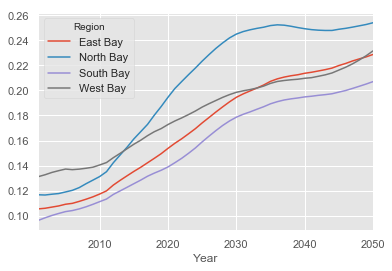

In [212]:
## check senior trend
rv_ag65p.T['R6H2C_COVID_basic'].plot()

#### Load labor force frames

In [213]:
import fnmatch
matches = []
for root, dirnames, filenames in os.walk(os.path.join(drop,'Data/REMI/labor')):
    for filename in fnmatch.filter(filenames, 'lfpr_gender*.xlsx'):
        matches.append(os.path.join(root, filename))

outlfpr={}
for fn in matches:
    scen=fn.split('/')[-2]
    
    ## only load file if in scenarios dict defined above
    this_scen=fn.split(os.path.sep)[-2]
    if this_scen in scenarios:
        tmplfpr=pd.read_excel(fn,sheet_name='All',skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outlfpr[scen]=tmplfpr

outlfpr=pd.concat(outlfpr,names=['runid']).reset_index(1,drop=True).reset_index()
rv_S_lf_female=outlfpr[outlfpr.Gender=='Female'].set_index(['runid','Region']).filter(regex='\d{4}')

rv_S_lf=outlfpr[outlfpr.Gender=='Total'].set_index(['runid','Region']).filter(regex='\d{4}')

#### Load industry and occupation frames

In [214]:
import fnmatch
matches = []
for root, dirnames, filenames in os.walk(os.path.join(drop,'Data/REMI/employment')):
    for filename in fnmatch.filter(filenames, 'hhinc 4 emp occ indus.xlsx'):
        matches.append(os.path.join(root, filename))


outocc=[]
outindus=[]
for fn in matches:
    this_scen=fn.split('/')[-2]
    if this_scen in scenarios:
    
        tmpocc=pd.read_excel(fn,sheet_name='Occupations',skiprows=4)
        tmpind=pd.read_excel(fn,sheet_name='Employment by Industry',skiprows=4)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outocc.append(tmpocc[tmpocc.Forecast==this_scen])
        outindus.append(tmpind[tmpind.Forecast==this_scen])

outocc=pd.concat(outocc)
outindus=pd.concat(outindus)

In [215]:
## mapping to SOC
occ_det_soc_map={'occ_det_mgmt':'11-0000',  ## mgmt
'occ_det_biz':'13-0000',   #  Business and Financial Operations Occupations
'occ_det_comp':'15-0000',   # Computer and Mathematical Occupations
'occ_det_community':'21-0000',  # Community and Social Service Occupations
'occ_det_lgl':'23-0000',  # legal
'occ_det_hlthsup':'31-0000',  # Healthcare Support Occupations
'occ_det_foodprep':'35-0000',  # Food Preparation and Serving Related Occupations
'occ_det_officeadmin':'43-0000'}#,  ## Office and Administrative Support Occupations

occ_det_soc_map={'11-0000': 'occ_det_mgmt',
 '13-0000': 'occ_det_biz',
 '15-0000': 'occ_det_comp',
 '21-0000': 'occ_det_community',
 '23-0000': 'occ_det_lgl',
 '31-0000': 'occ_det_hlthsup',
 '35-0000': 'occ_det_foodprep',
 '43-0000': 'occ_det_officeadmin'}

In [216]:
soc = pd.read_excel(os.path.join(drop,'Documents/Data/_BLS/SOC/soc_structure_2010.xls'),skiprows=11,
                   names=[u'Major Group', u'Minor Group', u'Broad Group', u'Detailed Occupation', u'Description'])
soc['soc_2']=soc['Major Group']#.fillna('').str.split('-').apply(lambda x: x[0])
soc['class']=soc.ix[:,:4].apply(classifier,axis=1)
soc['hierarchy']=soc['class'].fillna('-1').map(classlevel)
soc['Description']=soc.Description.fillna('0').str.lower()

soc=soc.append(pd.DataFrame(data={'Description':['counselors and social workers'],'soc_2':['21-0000'],'class':['21-0000']}))

soc['soc_2']=soc['soc_2'].fillna(method='ffill')
soc=soc[soc['soc_2'].notnull()]

In [217]:
# ### in the regressions, we have a few more detailed occupation groups now.

# acsocc= pd.read_excel('/Users/aolsen/Dropbox/Documents/Data/_Census/lookups/2018-occupation-code-list-and-crosswalk.xlsx','2018 Census Occ Code List',skiprows=4)
# acsocc['soc_maj']=acsocc['Unnamed: 0']
# acsocc['soc_maj']=acsocc['soc_maj'].fillna(method='ffill')

In [221]:
## Load occupation employment by scenario, sub-region
## Note: invariably fails to run the first time, with `remove_unused_levels` error. Second time always works.

outocc.loc[~outocc.Occupations.str.match(r'\s+'),'major_group']=outocc.loc[~outocc.Occupations.str.match(r'\s+')].Occupations
outocc.loc[outocc.Occupations.str.match(r'\s+'),'detail']=outocc.loc[outocc.Occupations.str.match(r'\s+')].Occupations.str.strip()
outocc['soc_2']=outocc.Occupations.str.lower().str.strip().map(soc.groupby('Description')['soc_2'].first())

outocc['occup_grp']=outocc.major_group.map(occ_to_census)
outocc['occup_grp_det']=outocc.soc_2.map(occ_det_soc_map)
outocc['occup_grp_det']=outocc['occup_grp_det'].fillna('Other Occupations')

outocc.major_group=outocc.major_group.fillna(method='ffill')
outocc=outocc[outocc.detail.notnull()]


In [222]:
empoccup_pct=outocc.groupby(['Forecast','Region','occup_grp']).sum().stack().groupby(level=[0,1,3]).apply(pct).unstack(3)

In [223]:
empoccup_det_pct=outocc.groupby(['Forecast','Region','occup_grp_det']).sum().stack().groupby(level=[0,1,3]).apply(pct).unstack(3)

In [224]:
#empoccup_det_pct.T['R6H2C_basic'].plot()

In [225]:
## Load industry employment by scenario, sub-region

outindus['naics']=outindus.Industries.str.extract("\(([0-9_\-,]+)\)")
outindus['industry_name']=outindus.Industries.str.split('(').apply(lambda x: x[0]).str.strip().str.title()
## keep only records with 2-digit detail
outindus=outindus.loc[outindus.naics.fillna('').str.contains('^\d{2}$|^\d{2}-\d{2}$')]
outindus['indus_grp']=outindus.industry_name.map(dict(zip(map(lambda x: x.title(),indus_to_census.keys()), indus_to_census.values())))

empindus_pct=outindus.groupby(['Forecast','Region','indus_grp']).sum().stack().groupby(level=[0,1,3]).apply(pct).unstack(3)

### Extract industry and occupation series

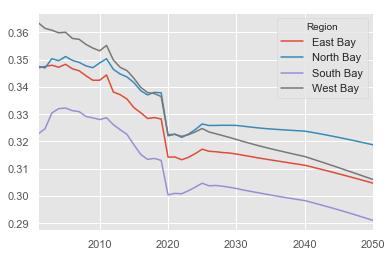

In [226]:
rv_S_ind_educ=empindus_pct.loc(0)[:,:,'ind_educ'].reset_index(2,drop=True)

rv_S_ind_retail = empindus_pct.loc(0)[:,:,'ind_retail'].reset_index(2,drop=True)
#rv_S_ind_public = empindus_pct.loc(0)[:,:,'ind_public']
rv_S_ind_accom_food_svcs = empindus_pct.loc(0)[:,:,'ind_accom_food_svcs'].reset_index(2,drop=True)
rv_S_ind_health = empindus_pct.loc(0)[:,:,'ind_health'].reset_index(2,drop=True)
rv_S_ind_prof = empindus_pct.loc(0)[:,:,'ind_prof'].reset_index(2,drop=True)

rv_S_occ_mgmt = empoccup_pct.loc(0)[:,:,'occ_mgmt'].reset_index(2,drop=True)
rv_S_occ_nat = empoccup_pct.loc(0)[:,:,'occ_nat'].reset_index(2,drop=True)
rv_S_occ_svcs = empoccup_pct.loc(0)[:,:,'occ_svcs'].reset_index(2,drop=True)
rv_S_occ_prod = empoccup_pct.loc(0)[:,:,'occ_prod'].reset_index(2,drop=True)
rv_S_occ_sls = empoccup_pct.loc(0)[:,:,'occ_sls'].reset_index(2,drop=True)

## check sales
rv_S_occ_sls.T['R6H2C_COVID_basic'].plot()

In [227]:
rv_S_occ_det_mgmt = empoccup_det_pct.loc(0)[:,:,'occ_det_mgmt'].reset_index(2,drop=True)
rv_S_occ_det_biz = empoccup_det_pct.loc(0)[:,:,'occ_det_biz'].reset_index(2,drop=True)
rv_S_occ_det_comp = empoccup_det_pct.loc(0)[:,:,'occ_det_comp'].reset_index(2,drop=True)
rv_S_occ_det_community = empoccup_det_pct.loc(0)[:,:,'occ_det_community'].reset_index(2,drop=True)
rv_S_occ_det_lgl = empoccup_det_pct.loc(0)[:,:,'occ_det_lgl'].reset_index(2,drop=True)
rv_S_occ_det_hlthsup = empoccup_det_pct.loc(0)[:,:,'occ_det_hlthsup'].reset_index(2,drop=True)
rv_S_occ_det_foodprep = empoccup_det_pct.loc(0)[:,:,'occ_det_foodprep'].reset_index(2,drop=True)
rv_S_occ_det_officeadmin = empoccup_det_pct.loc(0)[:,:,'occ_det_officeadmin'].reset_index(2,drop=True)

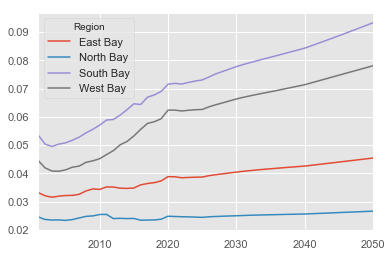

In [228]:
## check computer occupations
rv_S_occ_det_comp.T['R6H2C_COVID_basic'].plot()

In [229]:
## Load misc income output

matches = []
for root, dirnames, filenames in os.walk(os.path.join(drop,'Data/REMI/income')):
    for filename in fnmatch.filter(filenames, 'misc income.xlsx'):
        matches.append(os.path.join(root, filename))


outincome=[]

for fn in matches:
    
    this_scen=fn.split('/')[-2]
    if this_scen in scenarios:
        print this_scen
        tmp=pd.read_excel(fn,skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outincome.append(tmp[tmp.Forecast==this_scen])

outincome=pd.concat(outincome).set_index(['Forecast','Region','Category','Units']).filter(regex='\d{4}')

## turn into true values
outincome.loc(0)[:,:,:,'Thousands']*=1000
outincome.loc(0)[:,:,:,'Billions of Fixed (2009) Dollars']*=1e9

R5H0C
R6H2C_COVID_fix
RC5
R6H2C_plus
RC6_COVID
RC6
R6H2C_COVID_cross
R6H2C_COVID_basic
R6H2C_fix
R5H2C
R6H2C_basic
R5H1C


#### Extract wage, income series

In [230]:
rh_agg_wage_income=outincome.loc(0)[:,:,'Wages and Salaries'].reset_index(level=['Category','Units'],drop=True)

In [231]:
rv_cnty_to_us=outincome.loc(0)[:,:,'Relative Housing Price'].reset_index(level=['Category','Units'],drop=True)

In [232]:
real_pers_inc=outincome.loc(0)[:,:,'Personal Income'].reset_index(level=['Category','Units'],drop=True)

In [233]:
real_pers_inc_per_cap=outincome.loc(0)[:,:,'Personal Income'].reset_index(level=['Category','Units'],drop=True)/\
outincome.loc(0)[:,:,'Total Population'].reset_index(level=['Category','Units'],drop=True)

#### There are a few non-remi variables in use - like restrictiveness of development, size of region
Prep those, too.

In [234]:
## create wharton index for *each* year
years = range(2001,2051) if hist else range(2015,2051)

rv_wharton={}
for yr in years:
    rv_wharton[yr]=combo_remireg.set_index('Region').weighted
rv_wharton_geo=pd.concat(rv_wharton,names=['year']).unstack(0)

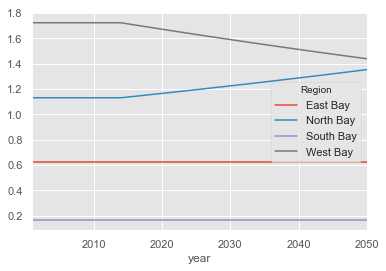

In [235]:
## adjust future expectations for tightness. South Bay is surprisingly low out of the box.
regionrates={'West Bay':.995,'South Bay':1,'East Bay':1,'North Bay':1.005}

rv_wharton_geo_adj = adjust_wharton_variable(rv_wharton_geo,regionrates)
rv_wharton_geo_adj.T.plot()

In [236]:

## create dummy frames denoting whether subregion is x or not, one for each subregion

length = years.__len__()
regions=['West Bay', 'East Bay', 'North Bay', 'South Bay', 'Rest of California']

mock_geodummies=pd.DataFrame(np.zeros([len(regions),len(years)],dtype='int'),index=regions,columns=years)
mock_geodummies.index.name='Region'

rv_is_north_bay=mock_geodummies.copy()
rv_is_north_bay.loc['North Bay']=1

rv_is_south_bay=mock_geodummies.copy()
rv_is_south_bay.loc['South Bay']=1

rv_is_east_bay=mock_geodummies.copy()
rv_is_east_bay.loc['East Bay']=1

rv_is_west_bay=mock_geodummies.copy()
rv_is_west_bay.loc['West Bay']=1

rv_is_rest_ca=mock_geodummies.copy()
rv_is_rest_ca.loc['Rest of California']=1

rv_msasize=rv_is_bay_area=mock_geodummies.copy().replace(0,1)
#        rv_msasize.loc['North Bay']=0

yearly=pd.DataFrame([years, years, years, years, years], columns=years,
             index=['West Bay', 'East Bay', 'North Bay', 'South Bay','Rest of California'])
yearly.index.name='Region'

rv_is_division_9=pd.DataFrame(
    [np.repeat(1,length), np.repeat(1,length), np.repeat(1,length), np.repeat(1,length), np.repeat(1,length)],
             columns=years,
             index=['West Bay', 'East Bay', 'North Bay', 'South Bay', 'Rest of California'])
rv_is_division_9.index.name='Region'

rv_is_not_division_9=pd.DataFrame(
    [np.repeat(0,length), np.repeat(0,length), np.repeat(0,length), np.repeat(0,length), np.repeat(0,length)],
             columns=years,
             index=['West Bay', 'East Bay', 'North Bay', 'South Bay', 'Rest of California'])
rv_is_not_division_9.index.name='Region'

yrseries = pd.Series(years)


## other misc variables

rv_density = county_area.loc[bayarearegions.keys()].rename(columns={'geoid.1':'geoid'})#.map(bayarearegions).reset_index(drop=True)
rv_density['Region']=rv_density.geoid.map(bayarearegions)
rv_density['population']=dataformodels['population'].xs('ACS2013')
rv_density=rv_density.groupby(['Region']).apply(lambda x: x['population'].sum()/x['aland'].sum())
rv_density=pd.concat([pd.DataFrame(data={'density':rv_density.repeat(years.__len__()),'variable':pd.concat([yrseries,yrseries,yrseries,yrseries]).values}).set_index('variable',append=True).unstack(1).density,pd.DataFrame(rv_is_not_division_9.loc['Rest of California',:]).T])
rv_density.index.name='Region'

In [242]:
## Use a dict to keep track of which regression source data is in memory
## Should be refactored to include runyears, input paths, whether to use PUMA income shares, etc

runstate={}

In [243]:
## set constant for whether to use income shares from PUMS data

use_pums_shares=True

hist = True

forecastyears=range(2015,2051)
input_path=os.path.join(box,'EDF Shared work/control_totals/remi')
input_path=os.path.join(box,'EDF Shared work/futures/future round2/models v2')
input_path

'/Users/aolsen/Box/EDF Shared work/futures/future round2/models v2'

### Estimate parameters for the four submodels

In [244]:
# xlsmodel = pd.ExcelWriter(os.path.join(drop,'Data/incomeregressions_scenario_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('__'.join(scenarios),datetime.datetime.now())))

# cat1_rhs_reg = ['ind_retail','ind_prof', 'ind_accom_food_svcs','occ_nat','Sother_NH','ag_65p','Swhite_NH','years']
# cat1_rhs_pums = ['np.log(inc_public_asst_adj2009)','np.log(inc_retirement_adj2009)','cnty_to_us','WRLURI','msasize==\'Above 1 million\'',  'occ_nat','ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
# cat1_rhs_pums = ['cnty_to_us',  'occ_nat','Swhite_NH','np.log(inc_public_asst_adj2009):ag_65p']

# cat1_rhs_pums = ['np.log(inc_public_asst_adj2009)','np.log(inc_retirement_adj2009)',
#                  'cnty_to_us','WRLURI','msasize==\'Above 1 million\'',  
#                  'occ_nat','ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
# cat1_params=run_model(cat1_rhs_pums if use_pums_shares else cat1_rhs_reg,inc_cat=1)

# cat2_rhs_reg = [ 'is_bay_area2','ind_educ','ind_retail','ind_accom_food_svcs','ind_health', 'ag_65p','Swhite_NH','years','np.log(per_capita_inc_adj2009)*ag_65p','years']
# cat2_rhs_pums = ['cnty_to_us','ind_health','ind_educ','Shispanic','ag_65p',]

# ## Specification, late Dec 2015
# cat2_rhs_pums = ['is_bay_area2','SLF','cnty_to_us','WRLURI','division==\'09\'','ind_health','ind_educ','Shispanic','ag_25_64','ag_65p']

# ## Specification 1, early Jan 2016
# cat2_rhs_pums = ['SLF','cnty_to_us','WRLURI','division==\'09\'','ind_health','ind_educ','Shispanic','ag_25_64','np.log(inc_public_asst_adj2009):ag_65p']
# cat2_params=run_model(cat2_rhs_pums if use_pums_shares else cat2_rhs_reg,inc_cat=2)

# cat3_rhs_reg = [ 'occ_svcs','occ_nat', 'Sother_NH', 'np.log(per_capita_inc_adj2009)','SLF','Swhite_NH','Shispanic','years']
# cat3_rhs_pums = ['ind_prof','is_bay_area2','SLF','Sblack_NH','ind_health','WRLURI']#,  ,,'np.log(per_capita_inc_adj2009)']
# cat3_rhs_pums = ['np.log(per_capita_inc_adj2009)','ind_prof','SLF','Sblack_NH','ind_health',
#                  'WRLURI','msasize==\'Above 1 million\'','ag_65p']#,  ,,'np.log(per_capita_inc_adj2009)']
# cat3_params=run_model(cat3_rhs_pums if use_pums_shares else cat3_rhs_reg,inc_cat=3)

# cat4_rhs_reg = ['msasize==\'Above 1 million\'', 'occ_svcs', 'occ_mgmt', 'Sother_NH', 'np.log(per_capita_inc_adj2009)','years','ag_15_24','ag_25_64','ag_65p','Sblack_NH','np.log(population)']
# cat4_rhs_pums = ['cnty_to_us','ind_public','is_bay_area2','w_sex', 'occ_mgmt','ind_prof']
# cat4_rhs_pums = ['cnty_to_us','ind_prof','Sblack_NH','ind_public','msasize==\'Above 1 million\'','ind_educ','w_sex', 'occ_mgmt*ind_prof']

# ## Specification, late Dec 2015
# cat4_rhs_pums = ['cnty_to_us','ind_prof','Sblack_NH','ind_public','msasize==\'Above 1 million\'','ind_educ','w_sex', 'occ_mgmt*ind_prof']

# ## Specification 1, early Jan 2016
# cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'','ind_educ','w_sex', 'occ_mgmt','occ_svcs','np.log(per_capita_inc_adj2009)']

# ## Specification 2, early Jan 2016
# cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 'occ_mgmt','occ_svcs','np.log(per_capita_inc_adj2009)','ag_65p']
# #cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 'occ_mgmt','occ_svcs','ag_65p',]
# #cat4_rhs_reg = ['msasize==\'Above 1 million\'', 'occ_svcs', 'occ_mgmt', 'Sother_NH', 'years','ag_15_24','ag_25_64','ag_65p','Sblack_NH','np.log(population)']

# ## Specification 3, early Jan 2016
# #cat4_rhs_pums = ['cnty_to_us']#'np.log(per_capita_inc_adj2009)']
# cat4_params=run_model(cat4_rhs_pums if use_pums_shares else cat4_rhs_reg,inc_cat=4)
# xlsmodel.close()

In [ ]:
## UPDATED specs Jan 2020 - retirement income no longer availalbe in REMI
## UPDATED data universe FEB 2020 - removal of smaller counties which may skew regressions

runstate['datauniv']='ALL'
xlsmodel = pd.ExcelWriter(os.path.join(drop,'Data/incomeregressions_scenario_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('__'.join(scenarios),datetime.datetime.now())))

cat1_rhs_reg = ['ind_retail','ind_prof', 'ind_accom_food_svcs','occ_nat','Sother_NH','ag_65p','Swhite_NH','years']
cat1_rhs_pums = ['np.log(inc_wage_adj2009)','cnty_to_us','WRLURI','msasize==\'Above 1 million\'',  'occ_nat','ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
cat1_rhs_pums = ['cnty_to_us',  'occ_nat','Swhite_NH','np.log(inc_public_asst_adj2009):ag_65p']

cat1_rhs_pums = ['np.log(inc_wage_adj2009)',
                 'cnty_to_us','WRLURI','msasize==\'Above 1 million\'',  
                 'occ_nat','ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
cat1_params=run_model(dataformodels,cat1_rhs_pums if use_pums_shares else cat1_rhs_reg,inc_cat=1)

cat2_rhs_reg = [ 'is_bay_area2','ind_educ','ind_retail','ind_accom_food_svcs','ind_health', 'ag_65p','Swhite_NH','years','np.log(per_capita_inc_adj2009)*ag_65p','years']
cat2_rhs_pums = ['cnty_to_us','ind_health','ind_educ','Shispanic','ag_65p',]

## Specification, late Dec 2015
cat2_rhs_pums = ['is_bay_area2','SLF','cnty_to_us','WRLURI','division==\'09\'','ind_health','ind_educ','Shispanic','ag_25_64','ag_65p']

## Specification 1, early Jan 2016
cat2_rhs_pums = ['SLF','cnty_to_us','WRLURI','division==\'09\'','ind_health',
                 'ind_educ','Shispanic','ag_25_64']#,'np.log(inc_wage_adj2009):ag_65p']


cat2_params=run_model(dataformodels,cat2_rhs_pums if use_pums_shares else cat2_rhs_reg,inc_cat=2)

cat3_rhs_reg = [ 'occ_svcs','occ_nat', 'Sother_NH', 'np.log(per_capita_inc_adj2009)','SLF','Swhite_NH','Shispanic','years']
cat3_rhs_pums = ['ind_prof','is_bay_area2','SLF','Sblack_NH','ind_health','WRLURI']#,  ,,'np.log(per_capita_inc_adj2009)']
cat3_rhs_pums = ['np.log(per_capita_inc_adj2009)','ind_prof','SLF','Sblack_NH','ind_health','cnty_to_us',
                 'WRLURI','msasize==\'Above 1 million\'','ag_65p']#,  ,,'np.log(per_capita_inc_adj2009)']
cat3_params=run_model(dataformodels,cat3_rhs_pums if use_pums_shares else cat3_rhs_reg,inc_cat=3)

cat4_rhs_reg = ['msasize==\'Above 1 million\'', 'occ_svcs', 'occ_mgmt', 'Sother_NH', 'np.log(per_capita_inc_adj2009)','years','ag_15_24','ag_25_64','ag_65p','Sblack_NH','np.log(population)']
cat4_rhs_pums = ['cnty_to_us','ind_public','is_bay_area2','w_sex', 'occ_mgmt','occ_nat']
cat4_rhs_pums = ['cnty_to_us','ind_prof','Sblack_NH','ind_public','msasize==\'Above 1 million\'','ind_educ','w_sex', 'occ_mgmt*ind_prof']

## Specification, late Dec 2015
cat4_rhs_pums = ['cnty_to_us','ind_prof','Sblack_NH','ind_public','msasize==\'Above 1 million\'','ind_educ','w_sex', 'occ_mgmt*ind_prof']

## Specification 1, early Jan 2016
cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'','ind_educ','w_sex', 'occ_mgmt','occ_svcs','np.log(per_capita_inc_adj2009)']

## Specification 2, early Jan 2016
cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 'occ_mgmt','occ_svcs','np.log(per_capita_inc_adj2009)','ag_65p']
#cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 'occ_mgmt','occ_svcs','np.log(inc_wage_adj2009)','ag_65p']
#cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 'occ_mgmt','occ_svcs','ag_65p',]
#cat4_rhs_reg = ['msasize==\'Above 1 million\'', 'occ_svcs', 'occ_mgmt', 'Sother_NH', 'years','ag_15_24','ag_25_64','ag_65p','Sblack_NH','np.log(population)']

## Specification 3, early Jan 2016
#cat4_rhs_pums = ['cnty_to_us']#'np.log(per_capita_inc_adj2009)']
cat4_params=run_model(dataformodels,cat4_rhs_pums if use_pums_shares else cat4_rhs_reg,inc_cat=4)
xlsmodel.close()

In [ ]:
## UPDATED data universe FEB 2020 - removal of smaller counties which may skew regressions
runstate['datauniv']='TOP_MSAS'

xlsmodel = pd.ExcelWriter(os.path.join(drop,'Data/incomeregressions_scenario_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('__'.join(scenarios),datetime.datetime.now())))

cat1_rhs_pums = ['np.log(inc_wage_adj2009)',
                 'cnty_to_us','WRLURI','msasize==\'Above 1 million\'',  
                 'occ_nat','ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
cat1_params=run_model(dataformodels_top50msas,cat1_rhs_pums if use_pums_shares else cat1_rhs_reg,inc_cat=1)

## Specification 1, early Jan 2016
cat2_rhs_pums = ['SLF','cnty_to_us','WRLURI','division==\'09\'','ind_health',
                 'ind_educ','Shispanic','ag_25_64']#,'np.log(inc_wage_adj2009):ag_65p']

cat2_params=run_model(dataformodels_top50msas,cat2_rhs_pums if use_pums_shares else cat2_rhs_reg,inc_cat=2)

cat3_rhs_pums = ['np.log(per_capita_inc_adj2009)','ind_prof','SLF','Sblack_NH','ind_health','cnty_to_us',
                 'WRLURI','msasize==\'Above 1 million\'','ag_65p']#,  ,,'np.log(per_capita_inc_adj2009)']
cat3_params=run_model(dataformodels_top50msas,cat3_rhs_pums if use_pums_shares else cat3_rhs_reg,inc_cat=3)

## Specification 2, early Jan 2016
cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 'occ_mgmt','occ_svcs','np.log(per_capita_inc_adj2009)','ag_65p']
cat4_params=run_model(dataformodels_top50msas,cat4_rhs_pums if use_pums_shares else cat4_rhs_reg,inc_cat=4)
xlsmodel.close()

In [ ]:
## TEST FOR PAUL F

## UPDATED data universe FEB 2020 - removal of smaller counties which may skew regressions
runstate['datauniv']='TOP_MSAS'

xlsmodel = pd.ExcelWriter(os.path.join(drop,'Data/incomeregressions_scenario_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('__'.join(scenarios),datetime.datetime.now())))

cat1_rhs_pums = ['np.log(inc_wage_adj2009)',
                 'np.log(per_capita_inc_adj2009)','WRLURI','msasize==\'Above 1 million\'',  
                 'occ_nat','ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
cat1_params=run_model(dataformodels_top50msas,cat1_rhs_pums if use_pums_shares else cat1_rhs_reg,inc_cat=1)

## Specification 1, early Jan 2016
cat2_rhs_pums = ['SLF','WRLURI','division==\'09\'',
                 'ind_health','np.log(per_capita_inc_adj2009)',
                 'ind_educ','Shispanic','ag_25_64']#,'np.log(inc_wage_adj2009):ag_65p']

cat2_params=run_model(dataformodels_top50msas,cat2_rhs_pums if use_pums_shares else cat2_rhs_reg,inc_cat=2)

cat3_rhs_pums = ['np.log(per_capita_inc_adj2009)','ind_prof','SLF','Sblack_NH',
                 'ind_health','np.log(per_capita_inc_adj2009)',
                 'WRLURI','msasize==\'Above 1 million\'','ag_65p']#,  ,,'np.log(per_capita_inc_adj2009)']
cat3_params=run_model(dataformodels_top50msas,cat3_rhs_pums if use_pums_shares else cat3_rhs_reg,inc_cat=3)

## Specification 2, early Jan 2016
cat4_rhs_pums = ['msasize==\'Above 1 million\'', 
                 'occ_mgmt','occ_svcs','np.log(per_capita_inc_adj2009)','ag_65p']
cat4_params=run_model(dataformodels_top50msas,cat4_rhs_pums if use_pums_shares else cat4_rhs_reg,inc_cat=4)
xlsmodel.close()

In [ ]:
## UPDATED data universe FEB 2020 - removal of smaller counties which may skew regressions
runstate['datauniv']='TOP_MSAS_ACS2013'

xlsmodel = pd.ExcelWriter(os.path.join(drop,'Data/incomeregressions_scenario_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('__'.join(scenarios),datetime.datetime.now())))

cat1_rhs_pums = ['np.log(inc_wage_adj2009)',
                 'cnty_to_us','WRLURI','msasize==\'Above 1 million\'',  
                 'occ_nat','ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
cat1_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat1_rhs_pums if use_pums_shares else cat1_rhs_reg,inc_cat=1)

## Specification 1, early Jan 2016
cat2_rhs_pums = ['SLF','cnty_to_us','WRLURI','division==\'09\'','ind_health',
                 'ind_educ','Shispanic','ag_25_64']#,'np.log(inc_wage_adj2009):ag_65p']

cat2_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat2_rhs_pums if use_pums_shares else cat2_rhs_reg,inc_cat=2)

cat3_rhs_pums = ['np.log(per_capita_inc_adj2009)','ind_prof','SLF','Sblack_NH','ind_health','cnty_to_us',
                 'WRLURI','msasize==\'Above 1 million\'','ag_65p']#,  ,,'np.log(per_capita_inc_adj2009)']
cat3_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat3_rhs_pums if use_pums_shares else cat3_rhs_reg,inc_cat=3)

## Specification 2, early Jan 2016
cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 'occ_mgmt','occ_svcs','np.log(per_capita_inc_adj2009)','ag_65p']
cat4_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat4_rhs_pums if use_pums_shares else cat4_rhs_reg,inc_cat=4)
xlsmodel.close()

In [ ]:
## UPDATED OCCUPATIONS and data universe MARCH 2020 - removal of smaller counties which may skew regressions
runstate['datauniv']='TOP_MSAS_ACS2013'

xlsmodel = pd.ExcelWriter(os.path.join(drop,'Data/incomeregressions_scenario_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('__'.join(scenarios),datetime.datetime.now())))

cat1_rhs_pums = [#'np.log(inc_wage_adj2009)',
                 'cnty_to_us','WRLURI','msasize==\'Above 1 million\'',  
                             'occ_det_officeadmin',
                 'occ_det_mgmt',#'occ_det_community',
                 'ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
cat1_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat1_rhs_pums if use_pums_shares else cat1_rhs_reg,inc_cat=1)

## Specification 1, early Jan 2016
cat2_rhs_pums = ['SLF','cnty_to_us','WRLURI','division==\'09\'',
                 'occ_det_officeadmin'
                 ,'occ_det_mgmt','occ_det_hlthsup',
                 #'ind_educ',
                 'Shispanic','Swhite_NH','ag_25_64']#,'np.log(inc_wage_adj2009):ag_65p']

cat2_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat2_rhs_pums if use_pums_shares else cat2_rhs_reg,inc_cat=2)

cat3_rhs_pums = ['np.log(per_capita_inc_adj2009)','ind_prof','SLF', 'Sother_NH','occ_det_foodprep',
                 'occ_det_hlthsup','cnty_to_us',
                 'WRLURI','msasize==\'Above 1 million\'','ag_65p']#,  ,,'np.log(per_capita_inc_adj2009)']
cat3_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat3_rhs_pums if use_pums_shares else cat3_rhs_reg,inc_cat=3)

## Specification 2, early Jan 2016
cat4_rhs_pums = ['cnty_to_us','msasize==\'Above 1 million\'', 
                 'occ_det_mgmt','occ_det_community',
                 #'occ_det_biz',
                 'np.log(per_capita_inc_adj2009)','ag_65p']
cat4_params=run_model(dataformodels_top50msas.loc['ACS2013'],cat4_rhs_pums if use_pums_shares else cat4_rhs_reg,inc_cat=4)
xlsmodel.close()

In [245]:
## UPDATED OCCUPATIONS and data universe MARCH 2020 - removal of smaller counties which may skew regressions
runstate['datauniv']='TOP30_MSAS_ACS2013'

xlsmodel = pd.ExcelWriter(os.path.join(drop,'Data/incomeregressions_scenario_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('__'.join(scenarios),datetime.datetime.now())))

cat1_rhs_pums = [#'np.log(inc_wage_adj2009)',
                 'cnty_to_us',#'WRLURI',
                'msasize==\'Above 1 million\'',  
                'occ_det_officeadmin',
                 'occ_det_mgmt',#'occ_det_community',
                 'ag_65p','Swhite_NH']#,'np.log(per_capita_inc_adj2009)']
cat1_params=run_model(dataformodels_top30msas.loc['ACS2013'],cat1_rhs_pums if use_pums_shares else cat1_rhs_reg,inc_cat=1)

## Specification 1, early Jan 2016
cat2_rhs_pums = ['SLF','cnty_to_us',#'WRLURI',
                 'division==\'09\'',
                 'occ_det_officeadmin'
                 ,'occ_det_mgmt','occ_det_hlthsup',
                 #'ind_educ',
                 'Shispanic','Swhite_NH','ag_25_64']#,'np.log(inc_wage_adj2009):ag_65p']

cat2_params=run_model(dataformodels_top30msas.loc['ACS2013'],cat2_rhs_pums if use_pums_shares else cat2_rhs_reg,inc_cat=2)

cat3_rhs_pums = ['np.log(per_capita_inc_adj2009)','ind_prof','SLF', 'Sother_NH','occ_det_foodprep',
                 'occ_det_hlthsup','occ_det_biz',#'cnty_to_us',
                 #'WRLURI',
                 'msasize==\'Above 1 million\'','ag_65p','ag_25_64']#,  ,,'np.log(per_capita_inc_adj2009)']
cat3_params=run_model(dataformodels_top30msas.loc['ACS2013'],cat3_rhs_pums if use_pums_shares else cat3_rhs_reg,inc_cat=3)

## Specification 2, early Jan 2016
cat4_rhs_pums = ['cnty_to_us',#'msasize==\'Above 1 million\'', 
                 'occ_det_mgmt','occ_det_community',
                 #'occ_det_biz',
                 'np.log(per_capita_inc_adj2009)','ag_25_64']
cat4_params=run_model(dataformodels_top30msas.loc['ACS2013'],cat4_rhs_pums if use_pums_shares else cat4_rhs_reg,inc_cat=4)
xlsmodel.close()

******************************************************************************** 

SUMMARY FOR INCOME BIN 1, (dep var: PUMS based shares)
                           Results: Ordinary least squares
Model:                     OLS                    Adj. R-squared:           0.745    
Dependent Variable:        inc_cat_1_pums         AIC:                      -505.1619
Date:                      2020-04-14 16:17       BIC:                      -483.9032
No. Observations:          154                    Log-Likelihood:           259.58   
Df Model:                  6                      F-statistic:              75.57    
Df Residuals:              147                    Prob (F-statistic):       1.95e-42 
R-squared:                 0.755                  Scale:                    0.0021069
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------

In [246]:
## these are the unique variables in the current submodel specifications
## To port to the NEW remi version 2.3, we need to re-create those from the new model structure

set(cat1_rhs_pums+cat2_rhs_pums +cat3_rhs_pums +cat4_rhs_pums )

{'SLF',
 'Shispanic',
 'Sother_NH',
 'Swhite_NH',
 'ag_25_64',
 'ag_65p',
 'cnty_to_us',
 "division=='09'",
 'ind_prof',
 "msasize=='Above 1 million'",
 'np.log(per_capita_inc_adj2009)',
 'occ_det_biz',
 'occ_det_community',
 'occ_det_foodprep',
 'occ_det_hlthsup',
 'occ_det_mgmt',
 'occ_det_officeadmin'}

In [247]:
output_path = os.path.join(box,'Modeling and Surveys/Regional Modeling/Housing/PBA50 Housing/PBA50 Household Forecast')

### Run the predictions

#### The main, quite unwieldy loop
* Runs through each scenario string defined earlier, loads REMI data (exported with "custom" format)
* Extact relevant variables and turn into future time series for future years, by subregion
* Multiply those variables with matching coefficients
* Scale to / constrain to 100% since we do four separate regressions in loop
* Index grow for each quartile to beginning year levels (there is no reason the prediction would actually predict the baseyear. Instead we just take that as given and move the needle based on the relative prediction.

In [248]:
## read baseline REFERENCE projection

projhh_reference=pd.read_csv(get_latest_scenario_proj('RC6'),index_col=[0])
projhh_reference.columns=projhh_reference.columns.astype(int)
projhh_reference=projhh_reference.stack()
projhh_reference.index=projhh_reference.index.set_names('Year',level=1)

<Figure size 792x576 with 0 Axes>

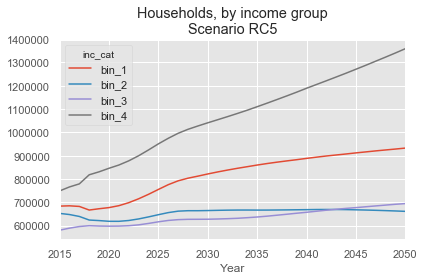

<Figure size 792x576 with 0 Axes>

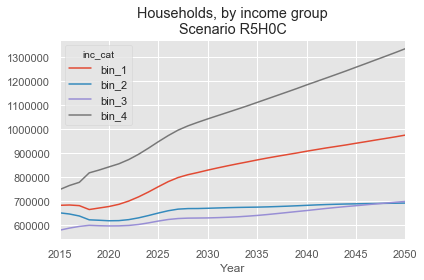

<Figure size 792x576 with 0 Axes>

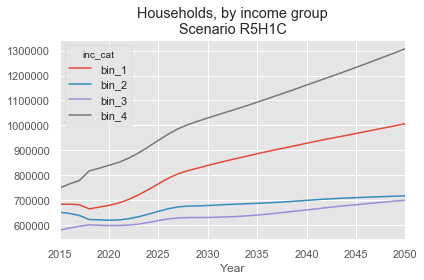

<Figure size 792x576 with 0 Axes>

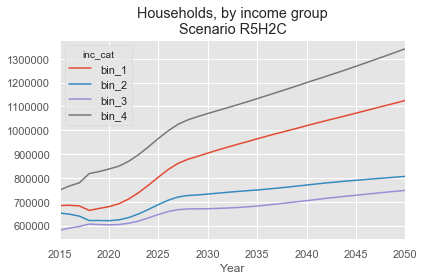

<Figure size 792x576 with 0 Axes>

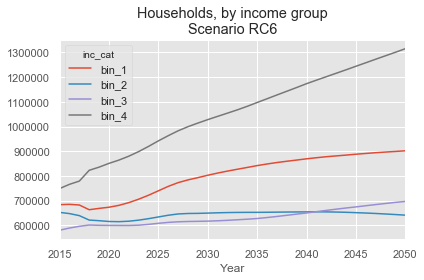

<Figure size 792x576 with 0 Axes>

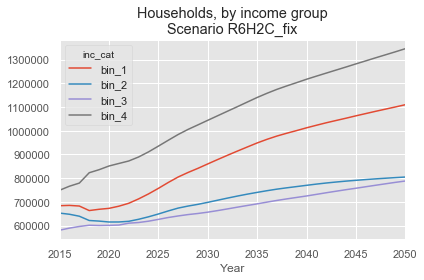

<Figure size 792x576 with 0 Axes>

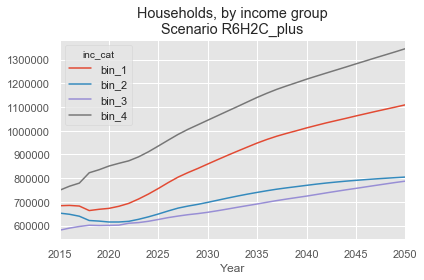

<Figure size 792x576 with 0 Axes>

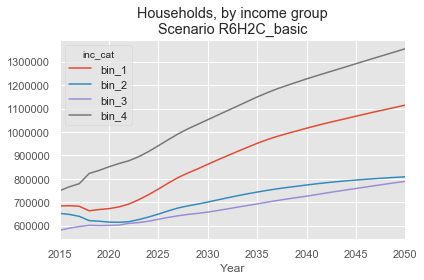

<Figure size 792x576 with 0 Axes>

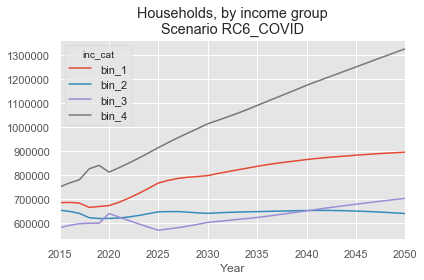

<Figure size 792x576 with 0 Axes>

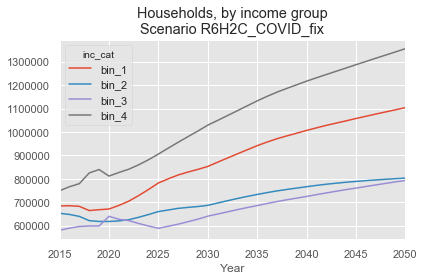

<Figure size 792x576 with 0 Axes>

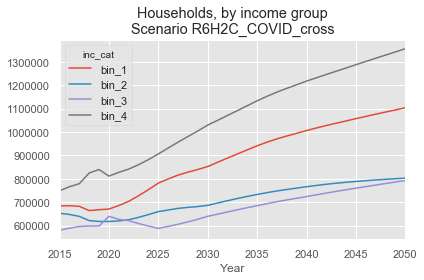

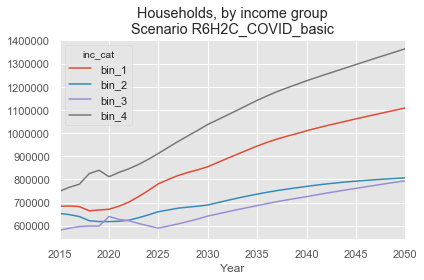

In [249]:
### PBA2050 VERSION

xlsoutput = pd.ExcelWriter(os.path.join(output_path,'incomeregressions_output_{}_{:%Y%m%d_%H%M%S}.xlsx'.format('_'.join(scenarios),datetime.datetime.now())))
STARTYEAR = 2015

## determines whether to load eased or 'raw' household projections 
## from `REGPROJ-HHPROJ 1 - Total household projection PBA2050 Phased HR.ipynb`

USE_EASED=True

## output containers - so we can store data for each scenario in a loop

incomekeep={}
outputcontainer={}
counterfactuals={}
rhs_plotting = {}
#coef_leverage_multiscenario={}
intercepts={}
coefficients={}
#coef_leverage_allscens={}
hhprojs = {}
racepop_combo={}
lfprdata_combo={}
agepop_combo={}
homeprices={}

# start logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# create a file handler
handler = logging.FileHandler(os.path.join(output_path,'incomeregressions_{:%Y%m%d_%H%M%S}.log'.format(datetime.datetime.now())))
handler.setLevel(logging.INFO)

# create a log format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# add the handler to the logger
logger.addHandler(handler)


with PdfPages(os.path.join(drop, 'plots/horizon/horizon_hhinc_timeseries_{datauniv}_{tme:%Y%m%d_%H%M%S}.pdf'.format(datauniv=runstate['datauniv'],tme=datetime.datetime.now()))) as pdf:
    for scenario in scenarios:
        
        ## load raw scenario-specific remi output and extract key variables
        
        logger.info("*"*80)
        logger.info("BEGINNING LOOP FOR SCENARIO {scen}".format(scen=scenario))
        logger.info("*"*80)
            
        
        ## For regression model grab vars at the subregion level
        ## Grab the relevant region-specific variables from the population and labor force dataframes
        ## These will be used to plug into REMI's regression equation later.

        ## save for later
        incomekeep[(scenario,'inc_RPI')]=real_pers_inc.loc[scenario]
        incomekeep[(scenario,'inc_RPIcap')]=real_pers_inc_per_cap.loc[scenario]
        incomekeep[(scenario,'inc_wage')]=rh_agg_wage_income.loc[scenario]
        
        
        # -------------------------------------------------------------------------

        ## Now, use parameters from each model to project future households by income bin.
        ## For each parameter from the estimated models, we multiply with the appropriate data points.

        ## TODO: Consider refactoring. Would be simpler to just use named series instead, and 
        ## then just multiply those with a similarly indexed series indexed on parameters holding estimates
        
        ## For now store variable name to dataframe relation in a dict
        param_to_var = {'WRLURI':rv_wharton_geo_adj,
                        #'np.log(inc_rental_adj2009)':np.log(rh_agg_rental_income),
                        #'np.log(inc_public_asst_adj2009)':np.log(rh_agg_public_asst_income),
                        #'np.log(inc_self_emp_adj2009)':np.log(rh_agg_self_emp_income),
                        'np.log(inc_wage_adj2009)':np.log(rh_agg_wage_income).loc[scenario],
                        #'np.log(inc_retirement_adj2009)':np.log(rh_agg_public_asst_income),
                        #'np.log(inc_public_asst_adj2009):ag_65p':np.log(rh_agg_public_asst_income)*rv_ag65p,
                        'SLF':rv_S_lf.loc[scenario],
                        'cnty_to_us':rv_cnty_to_us.loc[scenario],
                        'Sblack_NH':rv_Sblack_NH.loc[scenario],
                        'Shispanic':rv_Shispanic.loc[scenario],
                        'Sother_NH':rv_Sother_NH.loc[scenario],
                        'Swhite_NH':rv_Swhite_NH.loc[scenario],
                        'ag_15_24':rv_ag15_24.loc[scenario],
                        'ag_25_64':rv_ag25_64.loc[scenario],
                        'msasize == \'Above 1 million\'[T.True]':rv_msasize,
                        'occ_mgmt:occ_svcs':  rv_S_occ_mgmt.loc[scenario]*rv_S_occ_svcs.loc[scenario],             
                        'occ_mgmt:ind_prof':  rv_S_occ_mgmt.loc[scenario]*rv_S_ind_prof.loc[scenario],             
                        'division == \'09\'[T.True]':rv_is_division_9,
                        'division == \'03\'[T.True]':rv_is_not_division_9,
                        'division == \'06\'[T.True]':rv_is_not_division_9,
                        'division == \'04\'[T.True]':rv_is_not_division_9,
                        'is_bay_area2[T.ouside bay area]':rv_is_bay_area,
                        'ag_65p':rv_ag65p.loc[scenario],
                        'occ_mgmt':rv_S_occ_mgmt.loc[scenario],
                        'np.log(aland)':np.log(aland),
                        'occ_prod':rv_S_occ_prod.loc[scenario],
                        'occ_nat':rv_S_occ_nat.loc[scenario],
                        'occ_sls':rv_S_occ_sls.loc[scenario],
                        'occ_svcs':rv_S_occ_svcs.loc[scenario],
                        'occ_det_mgmt':rv_S_occ_det_mgmt.loc[scenario],
                        'occ_det_biz':rv_S_occ_det_biz.loc[scenario],
                        'occ_det_comp':rv_S_occ_det_comp.loc[scenario],
                        'occ_det_community':rv_S_occ_det_community.loc[scenario],
                        'occ_det_lgl':rv_S_occ_det_lgl.loc[scenario],
                        'occ_det_hlthsup':rv_S_occ_det_hlthsup.loc[scenario],
                        'occ_det_foodprep':rv_S_occ_det_foodprep.loc[scenario],
                        'occ_det_officeadmin':rv_S_occ_det_officeadmin.loc[scenario],
                        'ind_educ':rv_S_ind_educ.loc[scenario],
                        'ind_retail':rv_S_ind_retail.loc[scenario],
                        #'ind_public':rv_S_ind_public.loc[scenario],
                        'ind_accom_food_svcs':rv_S_ind_accom_food_svcs.loc[scenario],
                        'ind_health':rv_S_ind_health.loc[scenario],
                        'ind_prof':rv_S_ind_prof.loc[scenario],
                        'np.log(density)':np.log(rv_density),
                        #'np.log(per_capita_inc)': np.log(real_pers_inc_per_cap),
                        'per_capita_inc_adj2009': real_pers_inc_per_cap.loc[scenario],
                        'np.log(per_capita_inc_adj2009)': np.log(real_pers_inc_per_cap).loc[scenario], ## the remi variable is adjusted to 2009 dollars out of the box
                        'np.log(per_capita_inc_adj2009 + 1)': np.log(real_pers_inc_per_cap+1).loc[scenario],
                        'np.log(population)':np.log(futurepop).loc[scenario],
                        #'w_sex':rv_w_sex,
                        'years':yearly,
                        'Sother_NH:np.log(per_capita_inc)':np.log(real_pers_inc_per_cap).loc[scenario]*rv_Sother_NH.loc[scenario]}

        
        
        ## do the actual prediction - parameter times (future predicted) variable
        
        ## compile output into one list
        i=0
        yrs =range(STARTYEAR,2051)
        final = {}
        coef_leverage={}
        var_x_coef_submodels = {}
        var_x_coef_submodels_detail = {}
        
        ## we have variables for each submodel in a list. Loop through them and predict shares using models
        for i, prms in enumerate([cat1_params,cat2_params,cat3_params,cat4_params]):
            var_x_coef = {}
            for p, v in prms.iteritems():
                if p not in ['bin','Intercept','np.log(aland)']:
                    
                    ## fetch the corresponding series to the actually estimated model
                    param_times_data=(param_to_var[p].loc[:,yrs]*v)
                    var_x_coef[p]=param_times_data
                    #coef_leverage_allscens[(scenario,i+1,p)]=param_times_data
                    coefficients[(scenario,i+1,p)]=v

            
            ## after looping through submodels, we sum variables times coefficients, and add intercept
            
            var_x_coef_submodels[i]=pd.concat(var_x_coef).sum(level=1)+prms['Intercept']
            var_x_coef_submodels_detail[i]=pd.concat(var_x_coef)
            intercepts[(scenario,i)]=prms['Intercept']

        pd.concat(var_x_coef_submodels_detail).loc[:,range(2010,2051,5)].to_csv(os.path.join(drop,'Data/PBA2050/hhinc_coefficient_influence_%s.csv'%(scenario)))
        pd.concat(var_x_coef_submodels_detail).loc[:,[2010,2020,2030,2040]].to_excel(xlsoutput,'coef_infl_%s'%scenario)


        hhincproj = pd.concat(var_x_coef_submodels)
        hhincproj.index=hhincproj.index.set_names('bin',level=0)
        hhincproj=hhincproj.swaplevel(0,1)

        ## also keep this scenario's coeff times var influence for global sheet
        #coef_leverage_multiscenario[scenario]=pd.concat(var_x_coef_submodels_detail).loc[:,[2020,2030,2040,2050]]
        
        ## shares now predicted but we need to scale to 100% within each subregion        
        hhincproj_scaled = hhincproj.groupby(level='Region').apply(pct).stack().unstack('bin')


        ## subset to just the Bay Area subregions

        hhincproj_scaled_long = hhincproj_scaled.loc(0)[['East Bay','North Bay','West Bay','South Bay'],
                                            range(STARTYEAR,2051)]

        ## change column names, set indices
        hhincproj_scaled_long.columns=['inc_cat_%s_tot'%x for x in range(1,5)]
        #hhincproj_scaled_long.columns=hhincproj_scaled_long.columns.map(lambda x: 'inc_cat_{}_tot'.format(x))
        #hhincproj_scaled_long.columns=hhincproj_scaled_long.columns.set_names('inc_cat')

        hhincproj_scaled_long['what']='modeled'
        hhincproj_scaled_long=hhincproj_scaled_long.reset_index().set_index(['level_1','Region','what'])
        hhincproj_scaled_long.index=hhincproj_scaled_long.index.set_names(['vintage','remi_region','what'])
        hhincproj_scaled_long=hhincproj_scaled_long.stack().reset_index(name='share').rename(columns={'level_3':'inc_cat'})


        ## index growth to STARTYEAR levels (we do this using start and end year estimated shares)

        hhincproj_scaled_indexed = hhincproj_scaled_long.loc[hhincproj_scaled_long.vintage>=2015].set_index(['vintage','remi_region','what','inc_cat']).share
        hhincproj_scaled_indexed=hhincproj_scaled_indexed.unstack(['remi_region','inc_cat'])

        ## divide with startyear
        hhincproj_scaled_indexed=(hhincproj_scaled_indexed/hhincproj_scaled_indexed.xs(STARTYEAR))
        hhincproj_scaled_indexed=hhincproj_scaled_indexed.stack(level=['remi_region']).reset_index(level=1,drop=True)

        if use_pums_shares:
            #bayareashares_pums_2013 = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/pums_bayarea_income_shares_1990_2013.csv'))
            #bayareashares_pums_2013.rename(columns={'Region':'remi_region'},inplace=True)
            #bayareashares_pums_2013=bayareashares_pums_2013.loc[(bayareashares_pums_2013.YEAR==2013)&(bayareashares_pums_2013.remi_region!='outside bay area'),1:].set_index('remi_region')
            existing_shares=bayareashares_pums_2015.copy()
        else:
            assert 'Provide shares from ACS'
            break
            #existing_shares=incshares_nonpums.xs('ACS2013').stack().xs(2013).unstack(0).xs('observed')

        
        ## Then evolve existing income distribution by applying these indexed growth in shares to existing shares
        
        income_predicted_shares = (existing_shares.mul(hhincproj_scaled_indexed,axis=0)).stack().\
        groupby(level=[0,1]).apply(pct).reset_index(name='share').\
        rename(columns={'level_2':'inc_cat'})
        
        income_predicted_shares['what']='PBA2050'
        income_predicted_shares=income_predicted_shares.rename(columns={'vintage':'years'})
        income_predicted_shares['vintage']='projected'
        
        ## Do some minor reformating of dataframe
        ## reshape for easy dataframe x series multiplication, aligning on indices
        income_predicted_for_counts=income_predicted_shares.copy()
        income_predicted_for_counts['inc_cat']=\
        income_predicted_for_counts.inc_cat.str.extract('(\d)',expand=False).astype(np.int64)
        income_predicted_for_counts=income_predicted_for_counts.set_index(['remi_region','years','inc_cat']).unstack(2).share
        income_predicted_for_counts.index=income_predicted_for_counts.index.set_names(['Region','Year'])
  
        ## write out shares for R
#         predobs = pd.concat([mtc_pba2013,income_predicted_shares,incshare_pums_bayarea_subregions if use_pums_shares else incshares_nonpums_long],axis=0)#.stack().reset_index()#.rename(columns={'level_3':'inc_cat',0:'share'})
#         if use_pums_shares:
#             predobs.to_csv(os.path.join(drop, 'Data/incshares_%s_projected_observed_pums.csv'%scenario))
#         else:
#             predobs.to_csv(os.path.join(drop, 'Data/incshares_%s_projected_observed.csv'%scenario))


        ## ----------------------------------------------------------------------
        ## DONE WITH YEARLY INCOME BIN SHARE PREDICTION
        ## Now, we need to apply to the relevant household forecast to get counts
        ## ----------------------------------------------------------------------
        
        ## read latest projection of the relevant scenario
        projhh_current=pd.read_csv(get_latest_scenario_proj(scenario,use_eased=USE_EASED),index_col=[0])
        projhh_current.columns=projhh_current.columns.astype(int)
        projhh_current=projhh_current.stack()
        projhh_current.index=projhh_current.index.set_names(['Region','Year'])
        
        hhprojs[scenario]=projhh_current
        
        ## Drum roll - predicted households times predicted shares 
        ## scenario specific
        
        hhincproj_count = projhh_current.mul( income_predicted_for_counts.stack(),axis=0).loc[:,forecastyears].unstack('inc_cat')
        hhincproj_count['vintage']='Projection'
        hhincproj_count.set_index('vintage',append=True,inplace=True)
        hhincproj_count.index=hhincproj_count.index.reorder_levels([2,0,1])
        hhincproj_count.columns=hhincproj_count.columns.map(lambda x: 'bin_%s'%x)

        ## apply to *reference* projection instead - that is, use scenario-specific income shares,
        ## but use with BASELINE population instead of scenario.
        
        hhincproj_count_reference = projhh_reference.mul( income_predicted_for_counts.stack(),axis=0).loc[:,forecastyears].unstack('inc_cat')
        hhincproj_count_reference['vintage']='Projection REF'
        hhincproj_count_reference.set_index('vintage',append=True,inplace=True)
        hhincproj_count_reference.index=hhincproj_count_reference.index.reorder_levels([2,0,1])
        hhincproj_count_reference.columns=hhincproj_count_reference.columns.map(lambda x: 'bin_%s'%x)

        
        ## the 2010, 2015 counts come from one year pums files
        
        ## PUMS 2015 is about 20,000 higher than DOF's count. We scale back to DOF levels.
        scale_pums_to_2015=hhincproj_count.sum(level=[2]).loc[2015].sum()/bayareaincomeobs.sum(axis=1).loc[2015]
        scale_pums_to_2015=pd.Series(scale_pums_to_2015,index=pd.Index([2015]),name='YEAR')

        bayareaincomeobs.update(bayareaincomeobs.loc[[2015]].mul(scale_pums_to_2015,axis=0))
        
        hist_and_projected = pd.concat([bayareaincomeobs,#data2010.unstack(),
                     hhincproj_count.sum(level=[2]).loc[range(2020,2051,5)]])
        hist_and_projected.to_excel(xlsoutput,('%s_inc_proj'%scenario)[:30])
        outputcontainer[scenario]=hist_and_projected
        
        hist_and_projected_ref = pd.concat([bayareaincomeobs,#data2010.unstack(),
                     hhincproj_count_reference.sum(level=[2]).loc[range(2020,2051,5)]])
        
        counterfactuals[scenario]=hist_and_projected_ref

        ## RHS Plotting--future remi vars
        ## TODO: minor refactoring - we could use `param_to_var` instead and save this step
        
        for_rhs_plotting=pd.DataFrame(data={
            'occ_mgmt':rv_S_occ_mgmt.loc[:,range(2015,2051)].stack().loc[scenario],
                       'SLF':rv_S_lf.stack().loc[scenario],
                       'real_pers_inc':real_pers_inc_per_cap.stack().loc[scenario],
                       'lf_female':rv_S_lf_female.stack().loc[scenario],
                       'occ_mgmt':rv_S_occ_mgmt.loc[:,range(2015,2051)].stack().loc[scenario],
                       'occ_svcs':rv_S_occ_svcs.loc[:,range(2015,2051)].stack().loc[scenario],
                       'occ_prod':rv_S_occ_prod.loc[:,range(2015,2051)].stack().loc[scenario],
                       #'public_asst_income':rh_agg_public_asst_income.stack(),
                       'wage_income':rh_agg_wage_income.stack().loc[scenario],
                       #'self_emp_income':rh_agg_self_emp_income.stack(),
                       #'rental_income':rh_agg_rental_income.stack(),
                       'wharton_geo' : rv_wharton_geo.stack(),
                       'wharton_geo_adj' : rv_wharton_geo_adj.stack(),
                       'msasize' : rv_msasize.stack(),
                       'density' : rv_density.stack(),
                       'ind_educ' : rv_S_ind_educ.loc[:,range(2015,2051)].stack().loc[scenario],
                       'ind_retail' : rv_S_ind_retail.loc[:,range(2015,2051)].stack().loc[scenario],
                       #'ind_public' : rv_S_ind_public.loc[:,range(2015,2051)].stack(),
                       'ind_accom_food_svcs' : rv_S_ind_accom_food_svcs.loc[:,range(2015,2051)].stack().loc[scenario],
                       'ind_health' : rv_S_ind_health.loc[:,range(2015,2051)].stack().loc[scenario],
                       'ind_prof' : rv_S_ind_prof.loc[:,range(2015,2051)].stack().loc[scenario],
                       'occ_sls' : rv_S_occ_sls.loc[:,range(2015,2051)].stack().loc[scenario],
                       'Swhite_NH' : rv_Swhite_NH.stack().loc[scenario],
                       'Sother_NH' : rv_Sother_NH.stack().loc[scenario],
                       'Sblack_NH' : rv_Sblack_NH.stack().loc[scenario],
                       'Shispanic' : rv_Shispanic.stack().loc[scenario],
                       'ag15_24' : rv_ag15_24.stack().loc[scenario],
                       'ag25_64' : rv_ag25_64.stack().loc[scenario],
            
                        'occ_det_mgmt':rv_S_occ_det_mgmt.loc[:,range(2015,2051)].stack().loc[scenario],
                        'occ_det_biz':rv_S_occ_det_biz.loc[:,range(2015,2051)].stack().loc[scenario],
                        'occ_det_comp':rv_S_occ_det_comp.loc[:,range(2015,2051)].stack().loc[scenario],
                        'occ_det_community':rv_S_occ_det_community.loc[:,range(2015,2051)].stack().loc[scenario],
                        'occ_det_lgl':rv_S_occ_det_lgl.loc[:,range(2015,2051)].stack().loc[scenario],
                        'occ_det_hlthsup':rv_S_occ_det_hlthsup.loc[:,range(2015,2051)].stack().loc[scenario],
                        'occ_det_foodprep':rv_S_occ_det_foodprep.loc[:,range(2015,2051)].stack().loc[scenario],
                        'occ_det_officeadmin':rv_S_occ_det_officeadmin.loc[:,range(2015,2051)].stack().loc[scenario],
                        'ag65p' : rv_ag65p.stack().loc[scenario]})
        rhs_plotting[scenario]=for_rhs_plotting
        
        ## plot out the counts by bin
        
        fig=plt.figure(figsize=(11, 8))
        plt.tight_layout()
        hhincproj_count.sum(level=['Year']).loc[forecastyears].plot()
        plt.title('Households, by income group\nScenario %s'%(scenario))
        plt.tight_layout()
        pdf.savefig()
    
    plt.close(fig)

    
## Finally, write out *results*
pd.concat(outputcontainer,axis=0).astype(np.int64).to_excel(xlsoutput,'scenariocombo')
pd.concat(outputcontainer,axis=0).astype(np.int64).stack().reset_index(name='value').rename(columns={'level_0':'runid','level_1':'year','level_2':'bin'}).to_csv(os.path.join(output_path,'incomeproj_%s_%s.csv'%('_'.join(scenarios),runstate['datauniv'])))

## write out *right hand side* data
pd.concat(rhs_plotting).stack().reset_index(name='value').rename(columns={'level_0':'runid','level_1':'Region','level_2':'year','level_3':'variable'}).to_csv(os.path.join(drop,'Data/PBA2050/hhinc_rhs_vars_remi.csv'))

## write out coefficient influence
#pd.concat(coef_leverage_multiscenario).unstack(0).sort_index(level=[0,2]).stack(level=[0,1]).reset_index(name='value').rename(columns={'level_0':'income_bin','level_1':'variable','level_3':'year','level_4':'scenario'}).to_csv(os.path.join(drop,'Data/horizon/hhinc_coefficient_influence_scenarios.csv'))
#pd.concat(coef_leverage_multiscenario).unstack(0).sort_index(level=[0,2]).reset_index().to_excel(xlsoutput,'coef_infl_detail')
#pd.concat(coef_leverage_multiscenario).unstack(0).swaplevel(2,1).sort_index(level=[0,1]).sum(level=[0,1]).to_excel(xlsoutput,'coef_infl_summary')
#pd.Series(intercepts).reset_index().rename(columns={'level_0':'scenario','level_1':'bin',0:'intercept'}).to_excel(xlsoutput,'intercepts')
pd.Series(coefficients).reset_index().rename(columns={'level_0':'scenario','level_1':'bin','level_2':'variable',0:'coefficient'}).to_excel(xlsoutput,'coefficients')
df_intercept=pd.DataFrame(data={'value':pd.Series(intercepts)})
df_intercept['variable']='AAintercept'
df_intercept.set_index('variable',append=True,inplace=True)
df_intercept.index=df_intercept.index.set_names(['scenario','bin','variable'])

df_coefficient=pd.DataFrame(data={'value':pd.Series(coefficients)})
df_coefficient.index=df_coefficient.index.set_names(['scenario','bin','variable'])
pd.concat([df_intercept,df_coefficient]).sort_index().unstack(0).to_excel(xlsoutput,'specifications')

## for r
file_for_r_index=pd.concat(outputcontainer,axis=0).astype(np.int64).unstack(0)
(file_for_r_index/file_for_r_index.iloc[0]).stack(level=[0,1]).\
reset_index(name='value').rename(columns={'level_0':'year','level_2':'runid','level_1':'bin'}).to_csv(os.path.join(drop,'Data/PBA2050/incomeproj_indx_%s.csv'%('_'.join(scenarios))))
pd.concat(rhs_plotting).stack().reset_index(name='value').rename(columns={'level_0':'runid','level_1':'Region','level_2':'year','level_3':'variable'}).to_excel(xlsoutput,'rhsdata')

xlsoutput.close()

logging.shutdown()

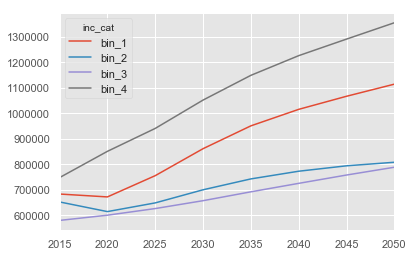

In [250]:
## what it looks like in 5-year increments
pd.concat(outputcontainer,axis=0).loc['R6H2C_basic'].iloc[1:].plot()

In [251]:
pd.concat(outputcontainer,axis=0).loc[['R6H2C_COVID_fix','R6H2C_COVID_cross']].stack().mean(level=[1,2]).sum(level=0)

2010   2,546,621.0
2015   2,665,734.0
2020   2,739,891.3
2025   2,936,127.6
2030   3,208,669.4
2035   3,492,276.6
2040   3,713,704.9
2045   3,893,037.4
2050   4,054,762.3
dtype: float64

#### How much within-bin difference across scenarios? What is the "intervention impact" across bins?

Counterfactual uses the reference projection levels but applies scenario inc distributions. Point is to make the income projections more "apples to apples", looking for variation not just due to the population totals differing between the variants. Instead, we hold counts constant for exposition.

In [252]:
regular_v_counterfactural=pd.concat([pd.concat(outputcontainer,axis=0).astype(np.int64).stack(),
     pd.concat(counterfactuals,axis=0).astype(np.int64).stack()],
          keys=['Regular','Counterfactual (RC6 levels)'],
         names=['variant','scenario','year','inc_cat'])


#.reset_index(name='value').to_csv(os.path.join(drop,'Data/PBA2050/regular_v_counterfactual.csv'))

In [253]:
#regular_v_counterfactural.unstack(0).diff(axis=1)['Counterfactual (RC5 levels)'].loc[variantscenario].unstack(2)

('RC6_COVID', 'R6H2C_COVID_basic')
('RC6_COVID', 'R6H2C_COVID_fix')
('RC6_COVID', 'R6H2C_COVID_cross')


Text(0.5,1.02,'Comparing RC6 Baseline with Each Variant\n20200414_161826')

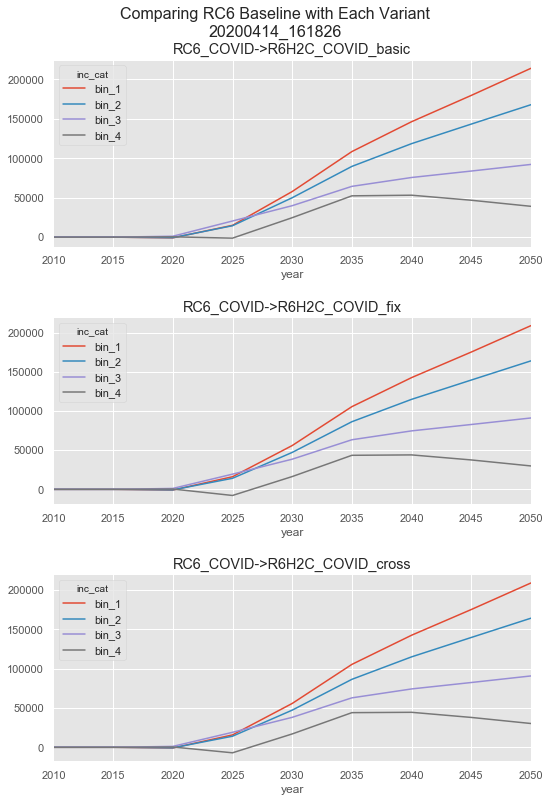

In [254]:
import itertools
fig,ax=plt.subplots(nrows=3,figsize=[8,11])
for row,k in enumerate(list(itertools.product(refscenario,variantscenario))):
    print k
    regular_v_counterfactural.loc['Regular',k].unstack('scenario').loc[:,k].diff(axis=1).loc[:,k[1]].unstack(2).reset_index(0,drop=True).plot(ax=ax[row])
    ax[row].set_title('->'.join(k))
fig.tight_layout(pad=2.0)
fig.suptitle('Comparing RC6 Baseline with Each Variant\n{:%Y%m%d_%H%M%S}'.format(datetime.datetime.now()),y=1.02,size=16)

In [255]:
#patn='({})'.format('|'.join(['Fut_backToTheFuture','Fut_cleanAndGreen','Fut_risingTidesFallingFortunes']))

In [256]:
# ## write out rhs data
# for_r_alt=pd.concat(rhs_plotting).stack().reset_index(name='value').rename(columns={'level_0':'runid','level_1':'Region','level_2':'year','level_3':'variable'})
# for_r_alt['group']=for_r_alt.runid.str.extract(patn,expand=False)
# for_r_alt['group2']=for_r_alt.runid.str.contains('_noeq').map({True:'No Earthquake',False:'Earthquake'})

# for_r_alt.to_csv(os.path.join(drop,'Data/hhinc_rhs_vars_remi.csv'))

### Household file deliverables

In [258]:
for k,v in scenarios_boxfoldermap.iteritems():
    newpath=os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}'.format(pth=v))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    print newpath

/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/Forecast 04132020/Blueprint Crossing
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/Forecast 04132020/Blueprint Plus Fix it First
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/Draft Forecast Base Case
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/Forecast 04132020/Blueprint Baseline
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/Forecast 04132020/Blueprint Basic
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/Draft Forecast Upper Case


In [259]:
## schema: 'bin_1':'q1_households' 	q2_households 	q3_households 	q4_households

for_urbansim=pd.concat(outputcontainer,axis=0,names=['scenario','year']).loc(0)[:,range(2015,2051,5)].reset_index()
for_urbansim['scenario_urbansim']=for_urbansim.scenario.map(scenarios_urbansim)
for_urbansim=for_urbansim[for_urbansim.scenario.isin(scenarios_urbansim)]
for_urbansim=for_urbansim.set_index(['year','scenario','scenario_urbansim']).filter(regex='bin').rename(columns=lambda x: 'q{}_households'.format(x[-1]))

In [260]:
pd.options.display.float_format = '{:,.1f}'.format
for_urbansim.loc(0)[:,BLUEPRINT_RUNS].stack()

year  scenario           scenario_urbansim            inc_cat      
2015  R6H2C_COVID_cross  23: Blueprint Plus Crossing  q1_households     683,941.5
                                                      q2_households     652,941.0
                                                      q3_households     580,498.1
                                                      q4_households     748,353.3
2020  R6H2C_COVID_cross  23: Blueprint Plus Crossing  q1_households     670,849.4
                                                      q2_households     617,711.3
                                                      q3_households     639,789.1
                                                      q4_households     811,541.5
2025  R6H2C_COVID_cross  23: Blueprint Plus Crossing  q1_households     781,702.9
                                                      q2_households     659,886.4
                                                      q3_households     588,232.1
                              

In [284]:
scenarios_boxfoldermap

{'R5H2C': 'Draft Forecast Upper Case',
 'R6H2C_COVID_basic': 'Forecast 04132020/Blueprint Basic',
 'R6H2C_COVID_cross': 'Forecast 04132020/Blueprint Crossing',
 'R6H2C_COVID_fix': 'Forecast 04132020/Blueprint Plus Fix it First',
 'RC5': 'Draft Forecast Base Case',
 'RC6_COVID': 'Forecast 04132020/Blueprint Baseline'}

In [261]:
(for_urbansim.loc(0)[:,BLUEPRINT_RUNS].stack().mean(level=['year','inc_cat']).unstack(1)/1e3).loc[2035].to_clipboard()

In [267]:
## write to CSV files on box

for nme, dta in for_urbansim.groupby(level=['scenario','scenario_urbansim']):
    print nme
    dta.reset_index([1,2],drop=True).round(0).astype(int).to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/household_controls_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))

('R5H2C', '17: Forecast test, less constrained')
('R6H2C_COVID_basic', '21: Blueprint Basic')
('R6H2C_COVID_cross', '23: Blueprint Plus Crossing')
('R6H2C_COVID_fix', '22: Blueprint Plus')
('RC5', '16: Forecast test, base')
('RC6_COVID', '20: No Project (Plan Bay Area 2050)')


In [268]:
for_urbansim.to_excel(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/household_controls_combo.xlsx'))

## prepare topsheet
Summary sheet with key regional variables from forecast

In [269]:
years_5=range(2015,2051,5)
output_path

'/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/Housing/PBA50 Housing/PBA50 Household Forecast'

In [270]:
xlsdata=pd.ExcelWriter(os.path.join(output_path,'topsheet_{:%Y%m%d_%H_%M}.xlsx'.format(datetime.datetime.now())))

In [271]:
topsheet_specs=pd.Series({'Bin 1': cat1_params,'Bin 2': cat2_params,'Bin 3': cat3_params ,
           'Bin 4': cat4_params}).apply(pd.Series,1).stack().\
reset_index(name='variable').rename(columns={'level_0':'Income Bin','level_1':'id'})
topsheet_specs=topsheet_specs[topsheet_specs['id']!='bin']
topsheet_specs.to_excel(xlsdata,'Model Specs')

In [272]:
#pd.Series({'Bin 1': cat1_params,'Bin 2': cat2_params,'Bin 3': cat3_params ,'Bin 4': cat4_params}).apply(pd.Series,1).stack().reset_index(name='variable').rename(columns={'level_0':'Income Bin','level_1':'id'}).to_excel(xlsdata,'Model Vars')

In [273]:
pd.concat(outputcontainer,axis=0,names=['scenario','year']).loc(0)[:,years_5].stack().unstack(1).round(0).astype(int).to_excel(xlsdata,'households_incbin')

In [274]:
remipop['age_num']=remipop.Ages.str.extract('(\d{1,3})').astype(int)#.groupby(['runid','Region','Year','age_grp_coarse']).value.sum()

In [275]:
## RACE

remi_race.groupby(level=['runid','Year','rac_ethn']).sum().loc[:,years_5].groupby(level=['runid','Year']).apply(pct).unstack('Year').to_excel(xlsdata,'race')
remi_age.groupby(level=['runid','Year','age_grp_coarse']).sum().loc[:,years_5].groupby(level=['runid','Year']).apply(pct).unstack('Year').to_excel(xlsdata,'age_grp_coarse')


remi_age.sum(level=[0,2]).loc[:,years_5].unstack(1).to_excel(xlsdata,'population')

In [276]:
remipop_age_pct=remipop.groupby(['runid','Year','age_num']).value.sum().loc[:,years_5].groupby(level=[0,1]).apply(pct).unstack('age_num')
agepop_cumsum=remipop_age_pct.cumsum(axis=1)

In [277]:
interval_begin=np.arange(0,100)
interval_end=np.arange(1,101)-.001

Text(0.5,1,'Median Age, by REMI variant\nSource: ABAG/MTC staff, from REMI')

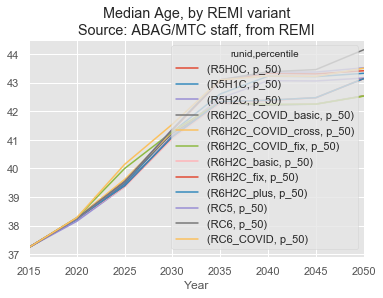

In [278]:
percentiles=[.1,.25,.5,.75,.9]
percentiles=[.5]
percentiledata={}
for p in percentiles:
    agepop_cumsum['middle_bin_start']=agepop_cumsum.apply(lambda x: interval_begin[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['middle_bin_start_share']=agepop_cumsum.apply(lambda x: x[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['middle_bin_end']=agepop_cumsum.apply(lambda x: interval_end[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['median']=agepop_cumsum.apply(lambda x: x.middle_bin_start+(p-x.middle_bin_start_share)*x.middle_bin_start,axis=1)
    #print agepop_cumsum['median'].head()
    topsheet_age=agepop_cumsum['median'].unstack(1)
    percentiledata['p_{:02.0f}'.format(p*100)]=topsheet_age
pop_age_medians=pd.concat(percentiledata,axis=0,names=['percentile']).stack().unstack([1,0])
pop_age_medians.plot()
title('Median Age, by REMI variant\nSource: ABAG/MTC staff, from REMI')

In [279]:
pop_age_medians.to_excel(xlsdata,'age_median')

In [280]:
## set BEA to BLS scale factor
BEA_SCALE=1.25

In [281]:
(outocc.loc[(outocc.Region.isin(['East Bay','West Bay','North Bay','South Bay']))].groupby(['Forecast','major_group']).sum().filter(regex='\d{4}').stack().loc[:,:,years_5].unstack(2)*1e3/BEA_SCALE).round(0).astype(int64).to_excel(xlsdata,'emp_occup')

In [282]:
(outindus.loc[(outindus.Region.isin(['East Bay','West Bay','North Bay','South Bay']))].groupby(['Forecast','indus_grp']).sum().filter(regex='\d{4}').stack().loc[:,:,years_5].unstack(2)*1e3/BEA_SCALE).round(0).astype(int64).to_excel(xlsdata,'emp_indus')

In [283]:
xlsdata.close()